In [50]:
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import prune

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy

plt.rcParams['font.family'] = 'Bookman Old Style'

class Volterra_obj:
    def __init__(self, A, num_memory_levels, num_nl_orders):
        self.num_memory_levels = num_memory_levels
        self.num_nl_orders =  num_nl_orders
        self.A = A


class dataset:
    def __init__(self, x, y, num_training_points, num_validation_points, 
                 num_test_points, num_memory_levels_nn, training_start_idx=0):
        """
        Initialize dataset with flexible data split ranges.
        
        Args:
            x: Clean PA input signal
            y: PA output signal (distorted)
            num_training_points: Number of samples for training (default 5000)
            num_validation_points: Number of samples for validation (default 5000)
            num_test_points: Number of samples for test (default 10000)
            num_memory_levels_nn: Number of memory taps for NN features (default 3)
            training_start_idx: Starting index for training data (default 0)
        """
        self.num_training_points = num_training_points
        self.num_validation_points = num_validation_points
        self.num_test_points = num_test_points
        self.num_memory_levels_nn = num_memory_levels_nn  # For NN feature extraction
        self.x = x
        self.y = y
        
        # Calculate data split indices based on number of points
        self.training_start_idx = training_start_idx
        self.validation_start_idx = training_start_idx + num_training_points
        self.test_start_idx = self.validation_start_idx + num_validation_points

        self.model_training_input, self.model_training_output, self.training_phase, self.model_valid_input, self.model_valid_output, self.valid_phase = self.prepare_data()
        self.model_training_xfc = self.get_model_training_xfc()
        self.model_training_expected_output = self.get_model_training_expected_output()
        self.model_valid_xfc = self.get_valid_xfc()
        self.model_valid_expected_output = self.get_model_valid_expected_output()

        self.test_input, self.test_output = self.get_leftover_test_data()

        
    def phase_vector(self, x):    
        """Takes a vector x and returns a vector of phases of each element"""
        Ax = np.abs(x)
        return np.conj(x)/Ax

    def model_expected_output(self, y, phase, num_memory_levels):
        """
        Denormalize phase and prepare output for NN training.
        Input y: The target output (clean PA input x in our case)
        Returns: [I, Q] pairs after phase denormalization
        """
        y_denorm = y*phase
        y_denorm_trim = y_denorm[num_memory_levels:]
        return np.array([np.real(y_denorm_trim), np.imag(y_denorm_trim)]).T

    def build_xfc(self, x):
        """
        Replicates the MATLAB build_xfc() function.
        Fixed: All features now use x[n-m] for proper time alignment.
        """
        num_points = len(x)
        phase = self.phase_vector(x)
        I = np.real(x)
        Q = np.imag(x)

        num_memory_levels = self.num_memory_levels_nn

        phase_norm_data = np.zeros((num_points, num_memory_levels), dtype=complex)
        for n in range(num_memory_levels, num_points):
            for m in range(num_memory_levels):
                phase_norm_data[n, m] = x[n - m] * phase[n]

        # Ax magnitude feature
        Ax = np.sqrt(I**2 + Q**2)

        # Build A feature matrix (Ax memory taps) - uses x[n-m]
        A_feats = np.zeros((num_points, num_memory_levels))
        for n in range(num_memory_levels, num_points):
            for m in range(num_memory_levels):
                A_feats[n, m] = Ax[n - m]

        # Trim first num_memory_levels samples (as in MATLAB)
        phase_norm_data = phase_norm_data[num_memory_levels:, :]
        A_feats = A_feats[num_memory_levels:, :]
        A3_feats = A_feats ** 3

        # Scale features to avoid large dynamic range
        # Phase-normalized features are already bounded (~[-1, 1])
        # Scale A_feats and A3_feats to similar range
    

        # Combine real and imaginary phase-normalized parts with scaled A-features
        xfc = np.hstack([
            np.real(phase_norm_data),
            np.imag(phase_norm_data),
            A_feats,
            A3_feats
        ]).astype(np.float32)

        return xfc

    def build_x_matrix(self, x, num_mem_levels, num_nl_orders):
        """Build Matrix X for find Volterra Model"""
        num_points = len(x)
        X = np.zeros((num_points, num_mem_levels * num_nl_orders), dtype=np.complex128)
        
        for n in range(num_mem_levels - 1, num_points):
            col = 0
            for i in range(num_mem_levels):
                xi = x[n - i]
                for j in range(num_nl_orders):
                    X[n, col] = (abs(xi) ** ((j) * 2)) * xi
                    col += 1

        return X

    def build_y(self, u, volterra_obj):
        """Builds y, the output of the volterra Model. Trims Output"""
        A = volterra_obj.A
        num_mem_levels = volterra_obj.num_memory_levels
        num_nl_orders = volterra_obj.num_nl_orders
        num_points = len(u)
        y = np.zeros((num_points, 1), dtype=np.complex128)
        for n in range(num_mem_levels - 1, num_points):
            col = 0 
            for i in range(num_mem_levels):
                ui = u[n-i]
                for j in range(num_nl_orders):
                    y[n]= y[n] + A[col]*(abs(ui)**(j*2)*ui)
                    col += 1
        y = y[num_mem_levels:]  # Use parameter, not self.num_memory_levels
        return y
            

    def volterra(self, input, output, num_nl_orders, num_memory_levels, check_conditioning=False):
        """
        Build component matrix A (Volterra coefficients)
        
        Args:
            input: Input signal
            output: Output signal
            num_nl_orders: Number of nonlinear orders
            num_memory_levels: Number of memory levels
            check_conditioning: If True, print condition number diagnostics
        
        Returns:
            Volterra coefficients
        """
        X = self.build_x_matrix(input, num_memory_levels, num_nl_orders)
        
        X_trim = X[num_memory_levels:, :]
        y_trim = output[num_memory_levels:]
        
        # Compute Gram matrix
        gram_matrix = X_trim.conj().T @ X_trim
        
        if check_conditioning:
            # Calculate condition number
            cond_num = np.linalg.cond(gram_matrix)
            print(f"\n{'='*60}")
            print(f"Volterra Matrix Conditioning Diagnostics")
            print(f"{'='*60}")
            print(f"Memory Levels: {num_memory_levels}")
            print(f"Nonlinear Orders: {num_nl_orders}")
            print(f"Matrix size: {gram_matrix.shape}")
            print(f"Condition Number: {cond_num:.2e}")
            
            if cond_num > 1e10:
                print("⚠️  WARNING: Matrix is ILL-CONDITIONED (cond > 1e10)")
                print("   Solutions may be numerically unstable!")
            elif cond_num > 1e6:
                print("⚠️  CAUTION: Matrix conditioning is marginal (cond > 1e6)")
            else:
                print("✓  Matrix is well-conditioned")
            
            # Check eigenvalues
            eigenvalues = np.linalg.eigvalsh(gram_matrix)
            print(f"Smallest eigenvalue: {np.min(np.abs(eigenvalues)):.2e}")
            print(f"Largest eigenvalue: {np.max(np.abs(eigenvalues)):.2e}")
            print(f"{'='*60}\n")
        
        A= np.linalg.pinv(gram_matrix) @ (X_trim.conj().T @ y_trim);
        return Volterra_obj(A, num_memory_levels, num_nl_orders)

    def training_data(self):
        """
        Assign training data for inverse PA model.
        In the imported data: x = clean PA input, y = PA output (distorted, no DPD)
        For inverse model (y -> x): input is PA output (y), output is clean input (x)
        
        Uses training_start_idx to select data region.
        """
        training_end_idx = self.training_start_idx + self.num_training_points
        idx_training = range(self.training_start_idx, training_end_idx - 1)

        model_training_input = self.y[idx_training]   # PA output (distorted)
        model_training_output = self.x[idx_training]  # Clean PA input (desired)
        return model_training_input, model_training_output
    

    def get_validation_data(self):
        """
        Assign validation data for inverse PA model.
        In the imported data: x = clean PA input, y = PA output (distorted, no DPD)
        
        Uses validation_start_idx and num_validation_points to select data region.
        """
        validation_end_idx = self.validation_start_idx + self.num_validation_points
        idx_validation = range(self.validation_start_idx, validation_end_idx - 1)
        
        model_valid_input = self.y[idx_validation]   # PA output (distorted)
        model_valid_output = self.x[idx_validation]  # Clean PA input (desired)
        return model_valid_input, model_valid_output
    
    def get_leftover_test_data(self):
        """
        Get data left over that wasn't used for validation or training.
        
        Uses test_start_idx and num_test_points to select data region.
        """
        test_end_idx = self.test_start_idx + self.num_test_points
        
        x_test = self.x[self.test_start_idx:test_end_idx]
        y_test = self.y[self.test_start_idx:test_end_idx]
        return x_test, y_test

    def prepare_data(self):
        """Prepare training and validation data sets"""
        # Training Data
        model_training_input, model_training_output = self.training_data()
        training_phase = self.phase_vector(model_training_input)

        # Validation Data
        model_valid_input, model_valid_output = self.get_validation_data()
        valid_phase = self.phase_vector(model_valid_input)
        return (model_training_input, model_training_output, training_phase,
                model_valid_input, model_valid_output, valid_phase)

    def get_model_training_xfc(self):
        """Build xfc from model training input using NN memory levels"""
        return self.build_xfc(self.model_training_input)
    
    def get_model_training_expected_output(self):
        """Find what the model should output for training data"""
        return self.model_expected_output(self.model_training_output, self.training_phase, self.num_memory_levels_nn)
    
    def get_valid_xfc(self):
        """Build xfc from model validation input using NN memory levels"""
        return self.build_xfc(self.model_valid_input)
    
    def get_test_xfc(self):
        return self.build_xfc(self.test_input)
    
    def get_model_valid_expected_output(self):
        """Find what the model should output for validation data"""
        return self.model_expected_output(self.model_valid_output, self.valid_phase, self.num_memory_levels_nn)

    
    def plot_volterra_vs_actual(self,volterra_obj, num_samples=800):
        """
        Plot Volterra model output vs actual PA output to validate model accuracy
        
        Args:
            A: Volterra coefficients
            num_memory_levels: Number of memory levels
            num_nl_orders: Number of nonlinear orders
            num_samples: Number of random samples to plot (default 800)
        """

        A = volterra_obj.A
        num_memory_levels = volterra_obj.num_memory_levels
        num_nl_orders = volterra_obj.num_nl_orders

        volterra_output = self.build_y(self.model_training_output, volterra_obj)
        actual_output = self.model_training_input[num_memory_levels:]
        input_trimmed = self.model_training_output[num_memory_levels:]

        # Select random data points
        total_points = len(input_trimmed)
        random_indices = np.random.choice(total_points, size=min(num_samples, total_points), replace=False)

        # Create scatter plot showing PA characteristic: input |x| vs output |y|
        plt.figure(figsize=(10, 8))
        plt.scatter(np.abs(input_trimmed[random_indices]), np.abs(actual_output[random_indices]), 
                    alpha=0.7, label='Actual PA Output', s=10, color='blue')
        plt.scatter(np.abs(input_trimmed[random_indices]), np.abs(volterra_output.squeeze()[random_indices]), 
                    alpha=0.7, label='Volterra Model Output', s=10, color='red')
        plt.plot([0, 1], [0, 1], 'k--', label='Linear (y=x)', linewidth=2)
        plt.xlabel('Input Magnitude |x|')
        plt.ylabel('Output Magnitude |y|')
        plt.title('PA Characteristics: Volterra Model vs Actual PA Output\n(Validation of Volterra Model Accuracy)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_pa_characteristic(self, num_samples=800):
        """
        Plot the PA input-output characteristic showing AM/AM compression and AM/PM distortion
        
        Args:
            num_samples: Number of random samples to plot (default 800)
        """
        # Use the actual PA input and output from training data
        # Use NN memory levels as a reasonable default for trimming
        pa_input = self.model_training_output[self.num_memory_levels_nn:]
        pa_output = self.model_training_input[self.num_memory_levels_nn:]

        # Select random data points for cleaner visualization
        total_points = len(pa_input)
        random_indices = np.random.choice(total_points, size=min(num_samples, total_points), replace=False)

        # Calculate phase difference (AM/PM distortion)
        phase_input = np.angle(pa_input[random_indices], deg=True)
        phase_output = np.angle(pa_output[random_indices], deg=True)
        phase_diff = phase_output - phase_input
        # Wrap phase difference to [-180, 180] degrees
        phase_diff = np.angle(np.exp(1j * np.deg2rad(phase_diff)), deg=True)

        # Create side-by-side plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
        
        # Plot 1: AM/AM characteristic (amplitude compression)
        ax1.scatter(np.abs(pa_input[random_indices]), np.abs(pa_output[random_indices]), 
                    alpha=0.7, label='PA Output', s=10, color='blue')
        ax1.plot([0, 1], [0, 1], 'k--', label='Linear (y=x)', linewidth=2)
        ax1.set_xlabel('PA Input Magnitude |x|', fontsize=12)
        ax1.set_ylabel('PA Output Magnitude |y|', fontsize=12)
        ax1.set_title('AM/AM Characteristic\n(Amplitude Compression)', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: AM/PM characteristic (phase distortion)
        ax2.scatter(np.abs(pa_input[random_indices]), phase_diff, 
                    alpha=0.7, label='Phase Distortion', s=10, color='red')
        ax2.axhline(0, color='k', linestyle='--', label='No distortion', linewidth=2)
        ax2.set_xlabel('PA Input Magnitude |x|', fontsize=12)
        ax2.set_ylabel('Phase Difference (degrees)', fontsize=12)
        ax2.set_title('AM/PM Characteristic\n(Phase Distortion)', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        plt.suptitle('Power Amplifier Nonlinear Characteristics', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
    def calculate_volterra_nmse(self, volterra_obj):
        """
        Calculate NMSE in dB for Volterra model prediction
        
        Args:
            A: Volterra coefficients
            num_memory_levels: Number of memory levels
            num_nl_orders: Number of nonlinear orders
            
        Returns:
            NMSE in dB
        """
        A = volterra_obj.A
        num_memory_levels = volterra_obj.num_memory_levels
        num_nl_orders = volterra_obj.num_nl_orders

        # Get Volterra model output (build_y trims num_memory_levels from output)
        volterra_output = self.build_y(self.test_input, volterra_obj).squeeze()
        actual_output = self.test_output[num_memory_levels:]
        
        # Ensure both arrays are the same length
        min_len = min(len(volterra_output), len(actual_output))
        volterra_output = volterra_output[:min_len]
        actual_output = actual_output[:min_len]
        
        # Calculate NMSE
        error_power = np.mean(np.abs(volterra_output - actual_output)**2)
        signal_power = np.mean(np.abs(actual_output)**2)
        nmse = error_power / signal_power
        nmse_db = 10 * np.log10(nmse)
        
        return nmse_db
    
    def plot_volterra_nmse_vs_memory_depth(self, num_nl_orders, max_memory_levels, check_conditioning=True):
        """
        Plot NMSE of Volterra model vs memory depth
        
        Args:
            num_nl_orders: Number of nonlinear orders (default 5)
            max_memory_levels: Maximum memory depth to test (default 10)
            check_conditioning: If True, check matrix conditioning for each memory depth
        """
        memory_depths = range(1, max_memory_levels + 1)
        nmse_values = []
        
        print("Computing NMSE for different memory depths...")
        for mem_depth in memory_depths:
            # Compute Volterra coefficients for this memory depth
            volterra_forward = self.volterra(input=self.model_training_output, output=self.model_training_input, 
                            num_nl_orders=num_nl_orders, num_memory_levels=mem_depth, 
                            check_conditioning=check_conditioning)
            
            # Calculate NMSE
            nmse_db = self.calculate_volterra_nmse(volterra_forward)
            nmse_values.append(nmse_db)
            
            print(f"Memory depth {mem_depth}: NMSE = {nmse_db:.2f} dB")
        
        # Plot results
        plt.figure(figsize=(10, 6))
        plt.plot(memory_depths, nmse_values, marker='o', linewidth=2, markersize=8, color='tab:blue')
        plt.xlabel('Memory Depth (Number of Memory Levels)', fontsize=12)
        plt.ylabel('NMSE (dB)', fontsize=12)
        plt.title(f'Volterra Model Performance vs Memory Depth\n(Nonlinear Orders = {num_nl_orders})', 
                  fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.xticks(memory_depths)
        
        plt.tight_layout()
        plt.show()
        
        return memory_depths, nmse_values

    def evaluate_inverse_volterra_through_pa(self, x, volterra_forward, volterra_inverse):
        """
        Evaluate inverse Volterra predistortion through PA model.
        
        Args:
            x: Input signal
            A_forward: Forward PA model coefficients
            A_inverse: Inverse model coefficients for predistortion
            num_memory_levels_forward: Memory levels for forward PA model
            num_nl_orders_forward: Nonlinear orders for forward PA model
            num_memory_levels_inverse: Memory levels for inverse model
            num_nl_orders_inverse: Nonlinear orders for inverse model
        """
        A_forward = volterra_forward.A
        num_memory_levels_forward = volterra_forward.num_memory_levels
        num_nl_orders_forward = volterra_forward.num_nl_orders


        A_inverse = volterra_inverse.A
        num_memory_levels_inverse = volterra_inverse.num_memory_levels
        num_nl_orders_inverse = volterra_inverse.num_nl_orders


        # Apply inverse Volterra (predistortion)
        volterra_predistorted_full = self.build_y(x, volterra_inverse).squeeze()
        
        # Pass through forward PA model
        pa_output = self.build_y(volterra_predistorted_full, volterra_forward).squeeze()
        
        # Align all arrays properly:
        # - x needs double trimming (sum of both memory levels)
        # - volterra_predistorted_full was trimmed once, needs one more trim
        # - pa_output is already double-trimmed implicitly
        total_trim = num_memory_levels_inverse + num_memory_levels_forward
        x_aligned = x[total_trim:]
        volterra_predistorted = volterra_predistorted_full[num_memory_levels_forward:]  # Align with x_aligned
        
        # Ensure same length
        min_len = min(len(pa_output), len(x_aligned), len(volterra_predistorted))
        x_aligned = x_aligned[:min_len]
        pa_output = pa_output[:min_len]
        volterra_predistorted = volterra_predistorted[:min_len]
        
        return x_aligned, volterra_predistorted, pa_output


# Load data
# PA_IO.mat contains:
#   x = clean input signal (what went into the PA)
#   y = PA output signal (distorted - no predistorter was used)
# Load data from CSV files
# CSV file paths
train_input_path = r"C:\Users\AQUIGNEY\Documents\College\OpenDPD\datasets\DPA_200MHz\train_input.csv"
train_output_path = r"C:\Users\AQUIGNEY\Documents\College\OpenDPD\datasets\DPA_200MHz\train_output.csv"
val_input_path = r"C:\Users\AQUIGNEY\Documents\College\OpenDPD\datasets\DPA_200MHz\val_input.csv"
val_output_path = r"C:\Users\AQUIGNEY\Documents\College\OpenDPD\datasets\DPA_200MHz\val_output.csv"
test_input_path = r"C:\Users\AQUIGNEY\Documents\College\OpenDPD\datasets\DPA_200MHz\test_input.csv"
test_output_path = r"C:\Users\AQUIGNEY\Documents\College\OpenDPD\datasets\DPA_200MHz\test_output.csv"

# Read CSV files (each has I and Q columns with headers in row 1)
train_input_df = pd.read_csv(train_input_path)
train_output_df = pd.read_csv(train_output_path)
val_input_df = pd.read_csv(val_input_path)
val_output_df = pd.read_csv(val_output_path)
test_input_df = pd.read_csv(test_input_path)
test_output_df = pd.read_csv(test_output_path)

# Convert I,Q columns to complex numbers
def iq_to_complex(df):
    """Convert DataFrame with I and Q columns to complex numpy array"""
    return (df['I'].values + 1j * df['Q'].values).astype(np.complex128)

# Create complex arrays for all datasets
train_input = iq_to_complex(train_input_df)
train_output = iq_to_complex(train_output_df)
val_input = iq_to_complex(val_input_df)
val_output = iq_to_complex(val_output_df)
test_input = iq_to_complex(test_input_df)
test_output = iq_to_complex(test_output_df)

# Concatenate all data: [train, validation, test]
# For inverse model: x = clean PA input (output), y = PA output (input)
x = np.concatenate([train_input, val_input, test_input]) 
y = np.concatenate([train_output, val_output, test_output])  
    

# Normalise both x and y 
x = x/np.max(x)
y = y/np.max(y)

# Data split configuration - now based on the CSV file sizes
num_training = len(train_input)      # Number of training samples from CSV
num_validation = len(val_input)      # Number of validation samples from CSV
num_test = len(test_input)           # Number of test samples from CSV
training_start = 0                    # Start at beginning since data is pre-split

num_memory_levels_volterra = 5 # Memory levels for Volterra PA model
num_memory_levels_nn = 11       # Memory levels for NN feature extraction (build_xfc) was 5

print(f"Data loaded from CSV files:")
print(f"  Training samples: {num_training}")
print(f"  Validation samples: {num_validation}")
print(f"  Test samples: {num_test}")
print(f"  Total samples: {len(x)}")

data_obj = dataset(x, y, 
                   num_training_points=num_training,
                   num_validation_points=num_validation,
                   num_test_points=num_test,
                   num_memory_levels_nn=num_memory_levels_nn,
                   training_start_idx=training_start)



Data loaded from CSV files:
  Training samples: 23040
  Validation samples: 7680
  Test samples: 7680
  Total samples: 38400


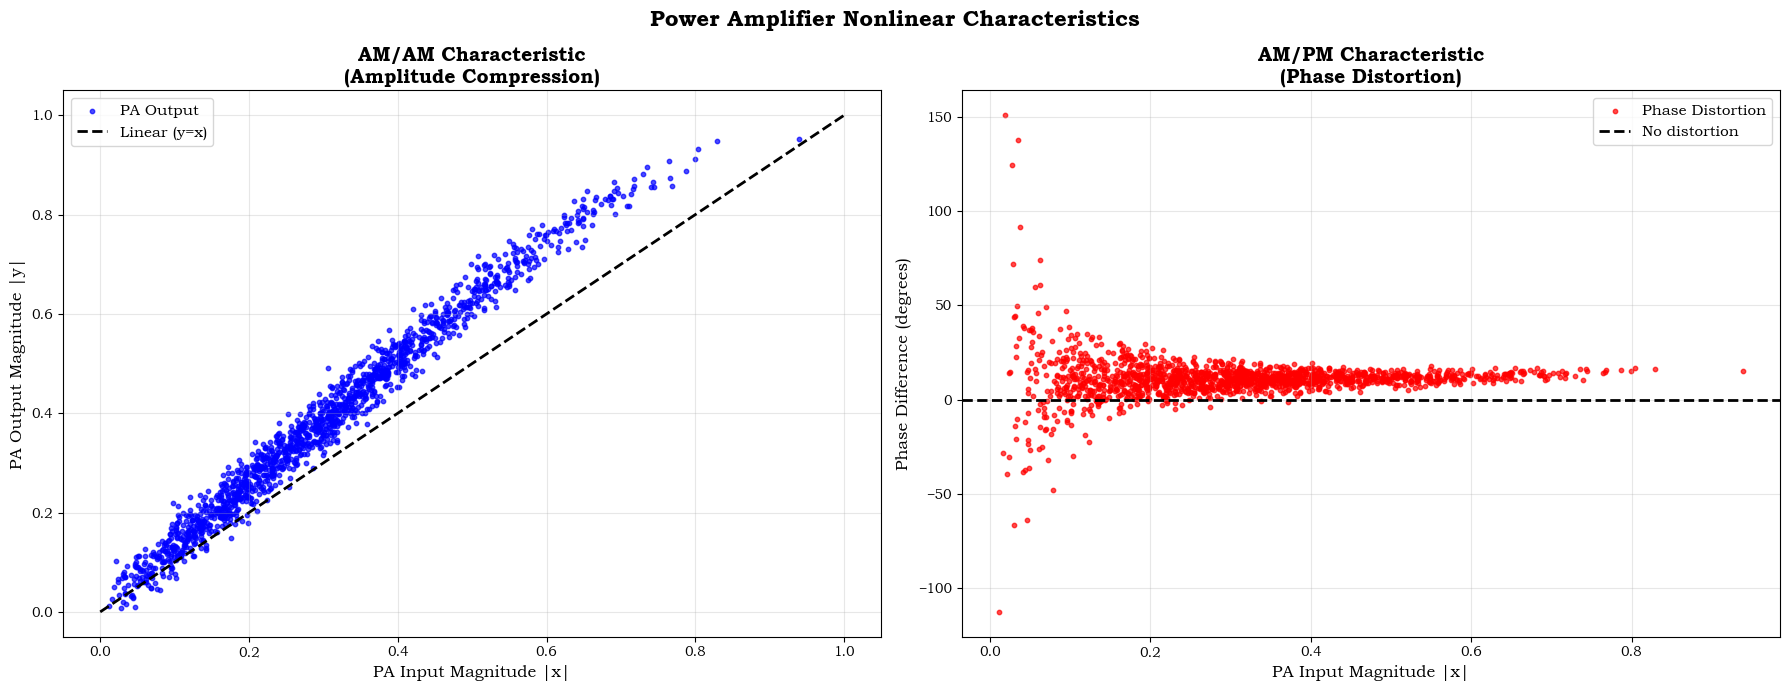

In [51]:
# Plot just the PA output characteristic (forward PA behavior)
data_obj.plot_pa_characteristic(num_samples=1500)


Computing NMSE for different memory depths...

Volterra Matrix Conditioning Diagnostics
Memory Levels: 1
Nonlinear Orders: 5
Matrix size: (5, 5)
Condition Number: 5.97e+05
✓  Matrix is well-conditioned
Smallest eigenvalue: 4.99e-03
Largest eigenvalue: 2.98e+03

Memory depth 1: NMSE = -20.76 dB

Volterra Matrix Conditioning Diagnostics
Memory Levels: 2
Nonlinear Orders: 5
Matrix size: (10, 10)
Condition Number: 1.40e+06
⚠️  CAUTION: Matrix conditioning is marginal (cond > 1e6)
Smallest eigenvalue: 4.05e-03
Largest eigenvalue: 5.65e+03

Memory depth 2: NMSE = -27.06 dB

Volterra Matrix Conditioning Diagnostics
Memory Levels: 3
Nonlinear Orders: 5
Matrix size: (15, 15)
Condition Number: 2.18e+06
⚠️  CAUTION: Matrix conditioning is marginal (cond > 1e6)
Smallest eigenvalue: 3.59e-03
Largest eigenvalue: 7.81e+03

Memory depth 2: NMSE = -27.06 dB

Volterra Matrix Conditioning Diagnostics
Memory Levels: 3
Nonlinear Orders: 5
Matrix size: (15, 15)
Condition Number: 2.18e+06
⚠️  CAUTION: Matrix

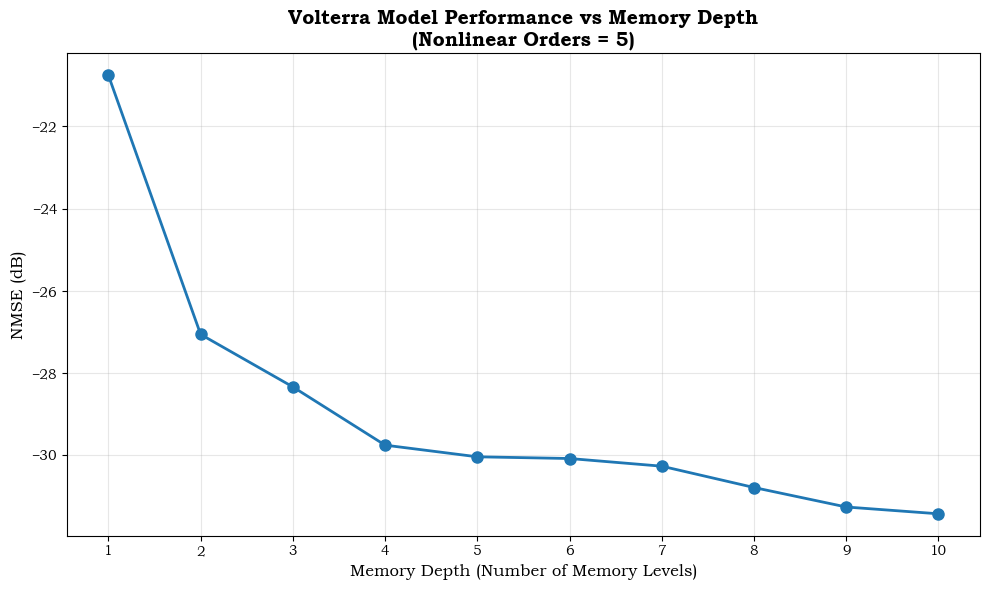

In [52]:
# Plot NMSE vs Memory Depth for Volterra Model
# This shows how model accuracy improves with more memory taps
memory_depths, nmse_values = data_obj.plot_volterra_nmse_vs_memory_depth(num_nl_orders=5, max_memory_levels=10)

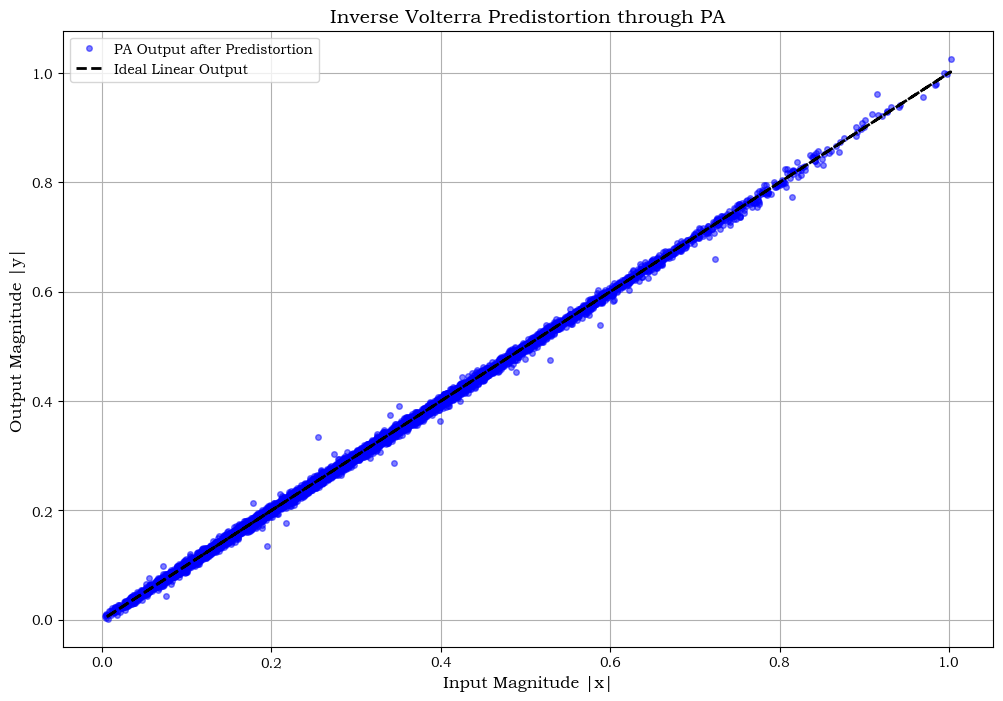

NMSE after Inverse Volterra Predistortion through PA: -33.40 dB


In [53]:
num_memory_levels_inverse = 3
num_nl_orders_inverse = 5

num_points = 7000

Volterra_inverse = data_obj.volterra(input=data_obj.model_training_input[:num_points],   
                               output=data_obj.model_training_output[:num_points], 
                               num_nl_orders=num_nl_orders_inverse, 
                               num_memory_levels=num_memory_levels_inverse)



num_nl_orders = 5
num_memory_levels_volterra = 5
Volterra_forward = data_obj.volterra(input=data_obj.model_training_output[:num_points],  
                      output=data_obj.model_training_input[:num_points],   
                      num_nl_orders=num_nl_orders, 
                      num_memory_levels=num_memory_levels_volterra)

x_aligned, volterra_predistorted, pa_output = data_obj.evaluate_inverse_volterra_through_pa(
    data_obj.test_input,  
    Volterra_forward,  
    Volterra_inverse)  

# Get unlinearized PA output for comparison (input goes directly through PA without DPD)
total_trim = num_memory_levels_volterra
test_input_trimmed = data_obj.test_input[total_trim:]
pa_output_no_dpd = data_obj.test_output[total_trim:]


# Align to match pa_output length
pa_output_no_dpd_aligned = pa_output_no_dpd[:len(pa_output)]

plt.figure(figsize=(12, 8))
plt.plot(np.abs(x_aligned), np.abs(pa_output), 'b.', alpha=0.5, label='PA Output after Predistortion', markersize=8)
plt.plot(np.abs(x_aligned), np.abs(x_aligned), 'k--', label='Ideal Linear Output', linewidth=2)
plt.xlabel('Input Magnitude |x|', fontsize=12)
plt.ylabel('Output Magnitude |y|', fontsize=12)
plt.title('Inverse Volterra Predistortion through PA', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

error_power = np.mean(np.abs(pa_output - x_aligned)**2)
signal_power = np.mean(np.abs(x_aligned)**2)
nmse_predistortion = error_power / signal_power
nmse_predistortion_db = 10 * np.log10(nmse_predistortion)
print(f'NMSE after Inverse Volterra Predistortion through PA: {nmse_predistortion_db:.2f} dB')


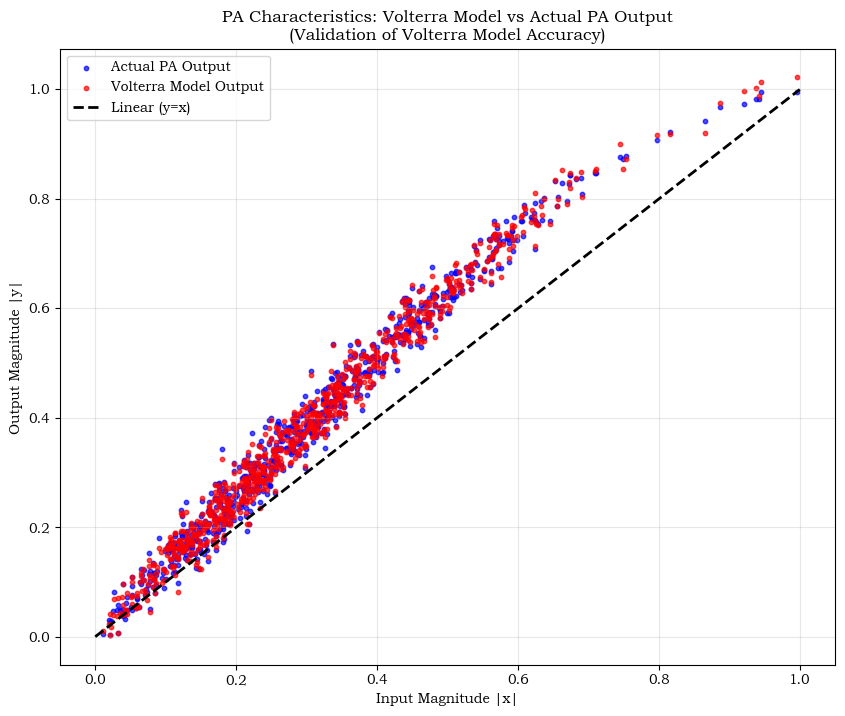

-29.960408720883148


In [54]:
# Plot the Volterra Model vs the Actual PA Output y (how similar is volterra to actual output)
data_obj.plot_volterra_vs_actual(Volterra_forward)
print(data_obj.calculate_volterra_nmse(Volterra_forward))

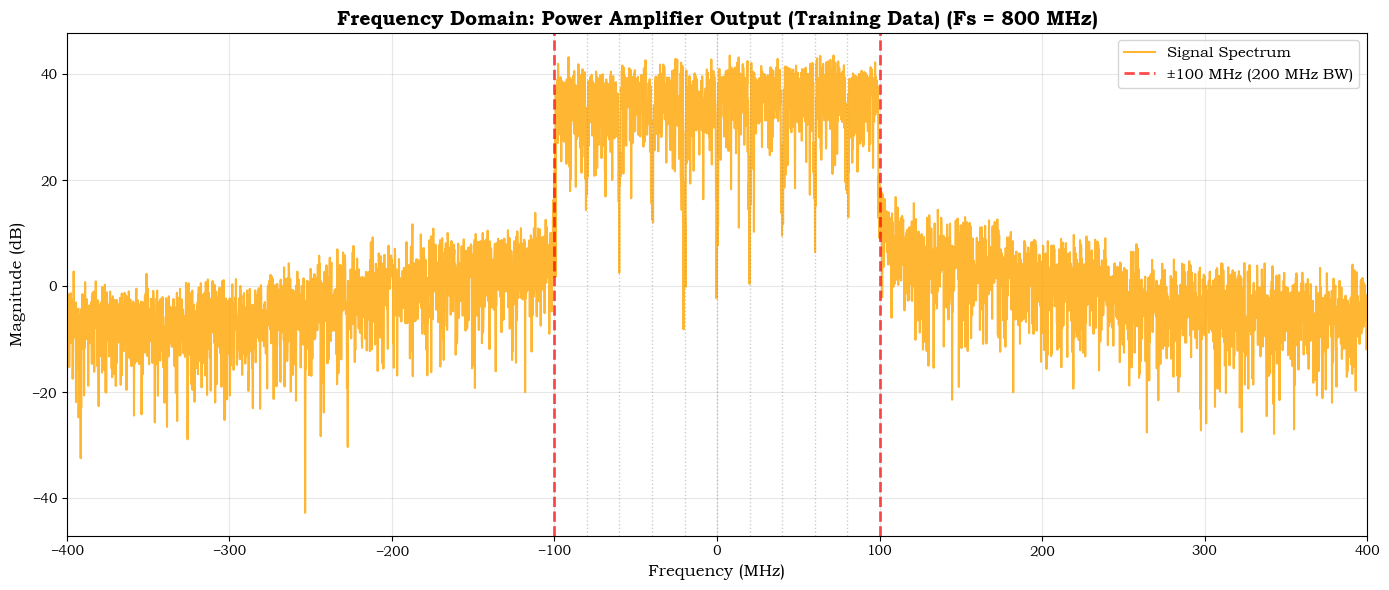

In [55]:
def plot_fft_data(y, y1=None, title_suffix="", fs=800e6, show_bw_lines=True, bw=200, num_points=1000):
    """
    Plot the FFT spectrum of the output data, optionally with a second signal
    
    Args:
        y: First signal to plot
        y1: Optional second signal to plot
        title_suffix: Title suffix for the plot
        fs: Sampling frequency in Hz (default: 1000 MHz = 1e9 Hz)
        show_bw_lines: Show bandwidth reference lines (default: True)
        bw: Signal bandwidth in MHz (default: 200 MHz)
    """
    # Compute FFT
    y = y[:num_points]
    Y = np.fft.fft(y, n=len(y))
    Y_flip = np.fft.fftshift(Y)
    # Convert to dB and take envelope (magnitude)
    Y_dB = 20 * np.log10(np.abs(Y_flip) + 1e-12)  # Add small value to avoid log(0)
    
    # Create frequency axis in MHz
    n = len(y)
    freq = np.fft.fftshift(np.fft.fftfreq(n, d=1/fs)) / 1e6  # Convert to MHz
    
    if y1 is not None:
        Y1 = np.fft.fft(y1, n=len(y1))
        Y1_flip = np.fft.fftshift(Y1)
        # Convert to dB and take envelope (magnitude)
        Y1_dB = 20 * np.log10(np.abs(Y1_flip) + 1e-12)
        
        # Create frequency axis for second signal
        n1 = len(y1)
        freq1 = np.fft.fftshift(np.fft.fftfreq(n1, d=1/fs)) / 1e6  # Convert to MHz
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: DPD Corrected
        ax1.plot(freq, Y_dB, color='orange', linewidth=1.5, alpha=0.8)
        if show_bw_lines:
            ax1.axvline(-bw/2, color='r', linestyle='--', label=f'±{bw/2:.0f} MHz ({bw:.0f} MHz BW)', alpha=0.7, linewidth=2)
            ax1.axvline(bw/2, color='r', linestyle='--', alpha=0.7, linewidth=2)
            # Add subchannel markers (10 subchannels, 20 MHz apart)
            for i in range(-5, 6):
                if i != -5 and i != 5:
                    ax1.axvline(i * 20, color='gray', linestyle=':', alpha=0.4, linewidth=1)
        ax1.set_title('DPD Corrected Signal Spectrum', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Frequency (MHz)', fontsize=12)
        ax1.set_ylabel('Magnitude (dB)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim([-fs/2e6, fs/2e6])
        if show_bw_lines:
            ax1.legend(fontsize=10)
        
        # Plot 2: Uncorrected PA Output
        ax2.plot(freq1, Y1_dB, color='blue', linewidth=1.5, alpha=0.8)
        if show_bw_lines:
            ax2.axvline(-bw/2, color='r', linestyle='--', label=f'±{bw/2:.0f} MHz ({bw:.0f} MHz BW)', alpha=0.7, linewidth=2)
            ax2.axvline(bw/2, color='r', linestyle='--', alpha=0.7, linewidth=2)
            # Add subchannel markers (10 subchannels, 20 MHz apart)
            for i in range(-5, 6):
                if i != -5 and i != 5:
                    ax2.axvline(i * 20, color='gray', linestyle=':', alpha=0.4, linewidth=1)
        ax2.set_title('Uncorrected PA Output Spectrum', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Frequency (MHz)', fontsize=12)
        ax2.set_ylabel('Magnitude (dB)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim([-fs/2e6, fs/2e6])
        if show_bw_lines:
            ax2.legend(fontsize=10)
        
        plt.suptitle(f'Frequency Domain: {title_suffix}', fontsize=16, fontweight='bold')
        plt.tight_layout()
    else:
        plt.figure(figsize=(14, 6))
        plt.plot(freq, Y_dB, linewidth=1.5, color='orange', alpha=0.8, label='Signal Spectrum')
        if show_bw_lines:
            plt.axvline(-bw/2, color='r', linestyle='--', label=f'±{bw/2:.0f} MHz ({bw:.0f} MHz BW)', alpha=0.7, linewidth=2)
            plt.axvline(bw/2, color='r', linestyle='--', alpha=0.7, linewidth=2)
            # Add subchannel markers (10 subchannels, 20 MHz apart)
            for i in range(-5, 6):
                if i != -5 and i != 5:
                    plt.axvline(i * 20, color='gray', linestyle=':', alpha=0.4, linewidth=1)
        plt.title(f'Frequency Domain: {title_suffix} (Fs = {fs/1e6:.0f} MHz)', fontsize=14, fontweight='bold')
        plt.xlabel('Frequency (MHz)', fontsize=12)
        plt.ylabel('Magnitude (dB)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xlim([-fs/2e6, fs/2e6])
        plt.legend(fontsize=11)
        plt.tight_layout()
    
    plt.show()

# Plot the PA output (distorted signal with intermodulation products)
plot_fft_data(data_obj.model_training_input, title_suffix="Power Amplifier Output (Training Data)", num_points=5000)


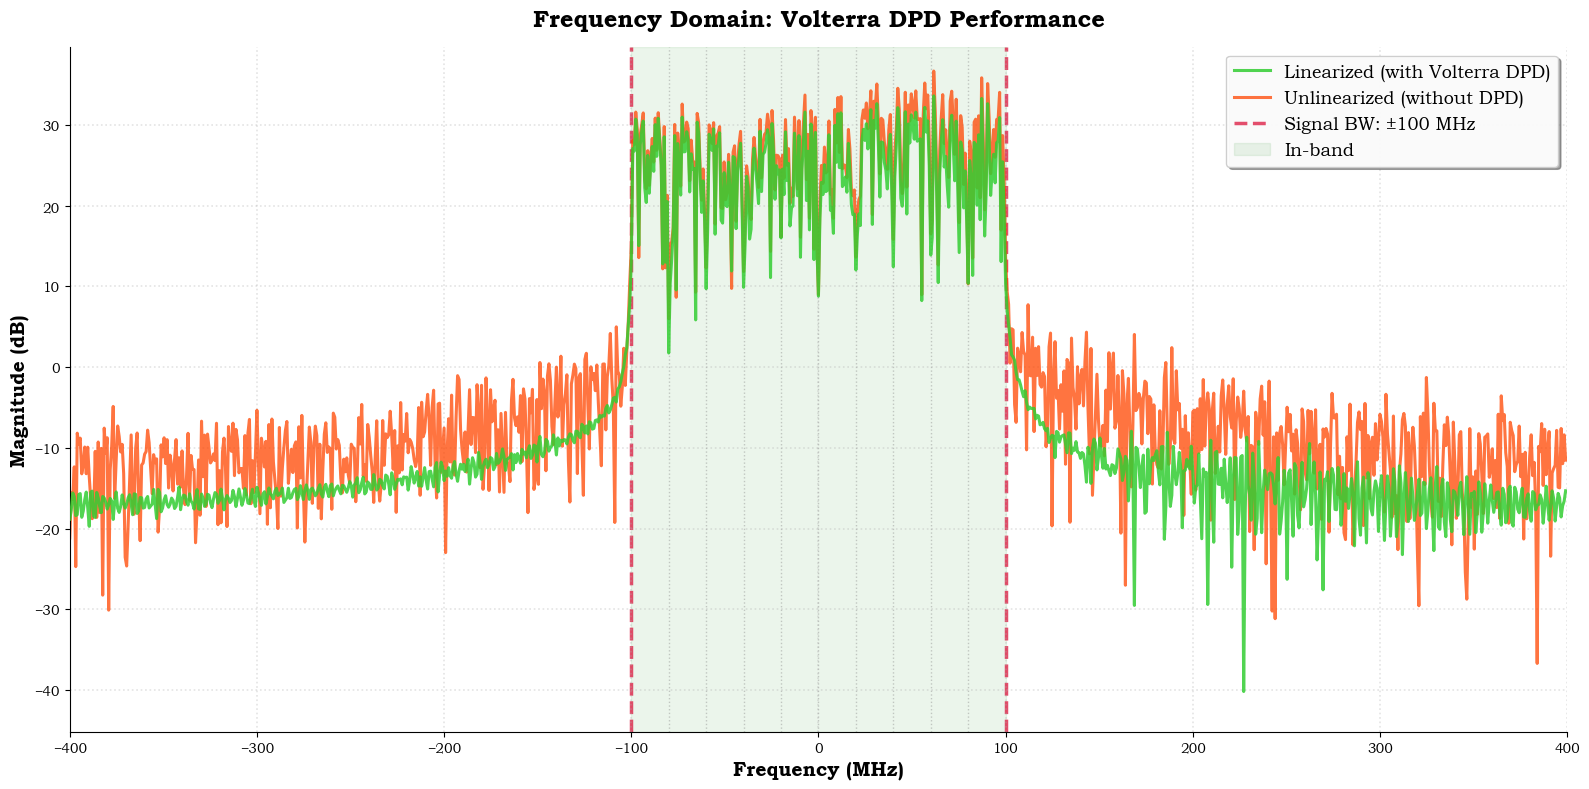

In [66]:
# FFT Overlay Plot
def fft_overlay(signal1, signal2, label1="Signal 1", label2="Signal 2", title="FFT Comparison", fs=800e6, show_bw_lines=True, bw=200, num_points=1000):
    """
    Plot FFT of two signals overlaid on the same graph
    
    Args:
        signal1: First signal (e.g., linearized PA output)
        signal2: Second signal (e.g., unlinearized PA output)
        label1: Label for first signal
        label2: Label for second signal
        title: Plot title
        fs: Sampling frequency in Hz (default: 1000 MHz = 1e9 Hz)
        show_bw_lines: Show bandwidth reference lines (default: True)
        bw: Signal bandwidth in MHz (default: 200 MHz)
    """
    # Compute FFT for signal 1
    signal1 = signal1[:num_points]
    Y1 = np.fft.fft(signal1, n=len(signal1))
    Y1_flip = np.fft.fftshift(Y1)
    Y1_dB = 20 * np.log10(np.abs(Y1_flip) + 1e-12)  # Add small value to avoid log(0)
    
    # Create frequency axis in MHz for signal 1
    n1 = len(signal1)
    freq1 = np.fft.fftshift(np.fft.fftfreq(n1, d=1/fs)) / 1e6  # Convert to MHz
    
    # Compute FFT for signal 2
    signal2 = signal2[:num_points]
    Y2 = np.fft.fft(signal2, n=len(signal2))
    Y2_flip = np.fft.fftshift(Y2)
    Y2_dB = 20 * np.log10(np.abs(Y2_flip) + 1e-12)
    
    # Create frequency axis in MHz for signal 2
    n2 = len(signal2)
    freq2 = np.fft.fftshift(np.fft.fftfreq(n2, d=1/fs)) / 1e6  # Convert to MHz
    
    # Create overlay plot with improved styling
    plt.figure(figsize=(16, 8))
    plt.plot(freq1, Y1_dB, color='#32CD32', linewidth=2.2, alpha=0.85, label=label1, zorder=3)
    plt.plot(freq2, Y2_dB, color='#FF4500', linewidth=2.2, alpha=0.75, label=label2, zorder=2)
    
    # Add bandwidth reference lines
    if show_bw_lines:
        plt.axvline(-bw/2, color='#DC143C', linestyle='--', 
                   label=f'Signal BW: ±{bw/2:.0f} MHz', alpha=0.75, linewidth=2.5, zorder=1)
        plt.axvline(bw/2, color='#DC143C', linestyle='--', alpha=0.75, linewidth=2.5, zorder=1)
        # Add shaded region for signal bandwidth
        plt.axvspan(-bw/2, bw/2, alpha=0.08, color='green', label='In-band', zorder=0)
        # Add subchannel markers (10 subchannels, 20 MHz apart)
        for i in range(-5, 6):  # -100 to +100 MHz in 20 MHz steps
            if i != -5 and i != 5:  # Skip the main bandwidth edges
                plt.axvline(i * 20, color='gray', linestyle=':', alpha=0.4, linewidth=1, zorder=0)
    
    plt.xlabel('Frequency (MHz)', fontsize=14, fontweight='semibold')
    plt.ylabel('Magnitude (dB)', fontsize=14, fontweight='semibold')
    plt.title(title, fontsize=17, fontweight='bold', pad=15)
    plt.legend(fontsize=13, loc='upper right', framealpha=0.95, shadow=True)
    plt.grid(True, alpha=0.35, linestyle=':', linewidth=1.2)
    plt.xlim([-fs/2e6, fs/2e6])
    
    # Set y-limits with some padding
    y_min = min(Y1_dB.min(), Y2_dB.min())
    y_max = max(Y1_dB.max(), Y2_dB.max())
    plt.ylim([y_min - 5, y_max + 3])
    
    # Remove top and right spines for cleaner look
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot FFT comparison
fft_overlay(pa_output, pa_output_no_dpd_aligned, 
           label1="Linearized (with Volterra DPD)", 
           label2="Unlinearized (without DPD)",
           title="Frequency Domain: Volterra DPD Performance")

In [57]:
# Train NN on backprop PA for inv model

class PNTDNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PNTDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    


class PNTDNN_3_layers(nn.Module):    
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(PNTDNN_3_layers, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 2)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

class NN:
    def __init__(self, dataset_obj, model_type):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_size = dataset_obj.model_training_xfc.shape[1]
        self.pntdnn = self.get_model(model_type)
        self.dataset_obj = dataset_obj
        self.train_loader = self.build_dataloaders(dataset_obj.model_training_xfc, dataset_obj.model_training_expected_output)
        self.valid_loader = self.build_dataloaders(dataset_obj.model_valid_xfc, dataset_obj.model_valid_expected_output)


    def get_model(self, model_type):
        if model_type == "one_layer_12_neurons":
            hidden_size = 12
            return PNTDNN(self.input_size, hidden_size)
        elif model_type == "one_layer_15_neurons":
            hidden_size = 15
            return PNTDNN(self.input_size, hidden_size)
        elif model_type == "two_layer_15_neurons":
            hidden_size1 = 15
            hidden_size2 = 15
            return PNTDNN_3_layers(self.input_size,hidden_size1, hidden_size2)
        else:
            raise ValueError("Unsupported model type")
        
    def build_dataloaders(self, x , y):
        X = torch.tensor(x, dtype=torch.float32)
        Y = torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X, Y)
        loader = DataLoader(dataset, batch_size=256, shuffle=True)
        return loader

    
    def get_best_model(self, num_epochs, learning_rate=1e-3):
        """Train model and return the best model based on validation loss"""
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.pntdnn.parameters(), lr=learning_rate)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
        
        train_losses = []
        valid_losses = []
        best_valid_loss = float('inf')
        best_model_state = None
        best_epoch = 0
        
        for epoch in range(num_epochs):
            self.pntdnn.train()
            running_train_loss = 0
            running_valid_loss = 0
            
            for xb, yb in self.train_loader:
                optimizer.zero_grad()
                preds = self.pntdnn(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * xb.size(0)
                
            train_loss = running_train_loss
            
            self.pntdnn.eval()
            with torch.no_grad():
                for xb, yb in self.valid_loader:
                    preds = self.pntdnn(xb)
                    loss = criterion(preds, yb)
                    running_valid_loss += loss.item() * xb.size(0)
                
            valid_loss = running_valid_loss
            
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            
            # Update learning rate based on validation loss
            scheduler.step(valid_loss)
            
            # Save best model
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_model_state = copy.deepcopy(self.pntdnn.state_dict())
                best_epoch = epoch + 1
            
            if (epoch + 1) % 10 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch + 1:3d}/{num_epochs}  Loss={train_loss:.4e}  Valid Loss={valid_loss:.4e}  LR={current_lr:.2e}")
        
        # Load best model
        self.pntdnn.load_state_dict(best_model_state)
        print(f"\nBest model from epoch {best_epoch} with validation loss: {best_valid_loss:.4e}")
        
        return train_losses, valid_losses, best_epoch

    def prune_model(self, parameters_to_prune_list, prune_amount=0.2):
        """Apply pruning to the model in-place"""
        parameters_to_prune = []

        if "fc1" in parameters_to_prune_list:
            parameters_to_prune.append((self.pntdnn.fc1, 'weight'))
        if "fc2" in parameters_to_prune_list:
            parameters_to_prune.append((self.pntdnn.fc2, 'weight'))
        if "fc3" in parameters_to_prune_list:
            parameters_to_prune.append((self.pntdnn.fc3, 'weight'))
        
        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=prune.L1Unstructured,
            amount=prune_amount,
        )
    
    def get_pruning_percentage(self):
        """Calculate the current percentage of pruned weights"""
        total_params = 0
        pruned_params = 0
        for name, module in self.pntdnn.named_modules():
            if isinstance(module, nn.Linear):
                if hasattr(module, 'weight_mask'):
                    mask = module.weight_mask
                    total_params += mask.numel()
                    pruned_params += (mask == 0).sum().item()
                else:
                    total_params += module.weight.numel()
        
        return (pruned_params / total_params * 100) if total_params > 0 else 0
    
    def calculate_nmse(self, volterra_forward, x):
        """Return NMSE in dB using formula: 10*log10(mean(|PA_output - x|^2) / mean(|x|^2))"""
        self.pntdnn.eval()
        # Evaluate output through PA (this handles all alignment automatically)
        x_aligned, nn_output, pa_output = self.evaluate_output_through_pa(
            self.dataset_obj, x, volterra_forward
        )
        
        # Calculate NMSE using the formula: 10 * log10(mean(|pa_output - x_aligned|^2) / mean(|x_aligned|^2))
        nmse_with_dpd = 10 * np.log10(np.mean(np.abs(pa_output - x_aligned)**2) / np.mean(np.abs(x_aligned)**2))
        
        return nmse_with_dpd
    
    def evaluate_nn_output(self, x):
        """Evaluate model output for given input x."""
        self.pntdnn.eval()
        with torch.no_grad():
            inputs = torch.tensor(x, dtype=torch.float32)
            outputs = self.pntdnn(inputs)
        return outputs.numpy()
    
    def evaluate_phase_denormalised_output(self, x, phase):
        """Evaluate model output for given input x with phase denormalization."""
        nn_outputs = self.evaluate_nn_output(x)
        output = (nn_outputs[:, 0] + 1j * nn_outputs[:, 1]) * np.conj(phase)
        return output
    
    def evaluate_output_through_pa(self, data_obj, x, volterra_obj):
        """
        Evaluate DPD system: x → NN (predistortion) → PA → output
        
        Args:
            data_obj: Dataset object (uses data_obj.num_memory_levels_nn for NN features)
            x: Input signal
            num_memory_levels_volterra: Memory levels for Volterra PA model
            num_nl_orders: Nonlinear orders for Volterra PA model
        
        Returns aligned arrays accounting for double trimming (build_xfc + build_y):
            x_aligned: Input signal trimmed by (num_memory_levels_nn + num_memory_levels_volterra)
            nn_output: NN predistorted output (trimmed by num_memory_levels_nn + num_memory_levels_volterra)
            pa_output: Final PA output (trimmed by num_memory_levels_nn + num_memory_levels_volterra)
        """
        # Build features from input signal using NN memory levels
        num_memory_levels_nn = data_obj.num_memory_levels_nn
        num_memory_levels_volterra = volterra_obj.num_memory_levels
        test_xfc = data_obj.build_xfc(x)

        # Get phase and trim it to match xfc length
        phase_full = data_obj.phase_vector(x)
        phase = phase_full[num_memory_levels_nn:]

        # Get NN output (predistorted signal u)
        nn_outputs = self.evaluate_nn_output(test_xfc)
        
        # Convert NN output back to complex form and denormalize
        nn_outputs_complex = (nn_outputs[:, 0] + 1j * nn_outputs[:, 1]) * np.conj(phase)
        
        # Pass through PA Volterra model (this trims another num_memory_levels_volterra samples)
        pa_output = data_obj.build_y(nn_outputs_complex, volterra_obj).squeeze()
        
        # Align all arrays properly:
        # - x needs double trimming (num_memory_levels_nn + num_memory_levels_volterra) because of build_xfc + build_y
        # - nn_outputs_complex was trimmed once (num_memory_levels_nn from build_xfc), needs volterra trim
        # - pa_output is already double-trimmed implicitly
        total_trim = num_memory_levels_nn + num_memory_levels_volterra
        x_aligned = x[total_trim:]
        nn_output = nn_outputs_complex[num_memory_levels_volterra:]  # Align with x_aligned
        
        # Ensure all arrays are same length
        min_len = min(len(pa_output), len(x_aligned), len(nn_output))
        x_aligned = x_aligned[:min_len]
        pa_output = pa_output[:min_len]
        nn_output = nn_output[:min_len]
        
        return x_aligned, nn_output, pa_output
    
    def evaluate_output_through_pa_nn(self, data_obj_inverse, x, forward_nn_model):
        """
        Evaluate DPD system using NN forward PA model: x → NN (predistortion) → NN PA Model → output
        
        Args:
            data_obj_inverse: Dataset object for inverse model (uses data_obj_inverse.num_memory_levels_nn)
            x: Input signal
            forward_nn_model: Forward NN PA model object
        
        Returns aligned arrays accounting for double trimming (build_xfc + build_xfc):
            x_aligned: Input signal trimmed by (num_memory_levels_inverse + num_memory_levels_forward)
            nn_dpd_output: NN predistorted output (trimmed appropriately)
            pa_nn_output: Final NN PA model output (trimmed appropriately)
        """
        # Get memory levels for both models
        num_memory_levels_inverse = data_obj_inverse.num_memory_levels_nn
        num_memory_levels_forward = forward_nn_model.dataset_obj.num_memory_levels_nn
        
        # Step 1: Build features from input signal using inverse NN memory levels
        inverse_xfc = data_obj_inverse.build_xfc(x)
        
        # Get phase for inverse NN denormalization
        phase_inverse_full = data_obj_inverse.phase_vector(x)
        phase_inverse = phase_inverse_full[num_memory_levels_inverse:]
        
        # Step 2: Get inverse NN output (predistorted signal u)
        nn_dpd_outputs = self.evaluate_nn_output(inverse_xfc)
        
        # Convert inverse NN output back to complex form and denormalize
        nn_dpd_complex = (nn_dpd_outputs[:, 0] + 1j * nn_dpd_outputs[:, 1]) * np.conj(phase_inverse)
        
        # Step 3: Pass predistorted signal through forward NN PA model
        # Build features for forward NN using its own memory levels
        forward_xfc = forward_nn_model.dataset_obj.build_xfc(nn_dpd_complex)
        
        # Get phase for forward NN denormalization
        phase_forward_full = forward_nn_model.dataset_obj.phase_vector(nn_dpd_complex)
        phase_forward = phase_forward_full[num_memory_levels_forward:]
        
        # Get forward NN output (PA output)
        pa_nn_outputs = forward_nn_model.evaluate_nn_output(forward_xfc)
        
        # Convert forward NN output back to complex form and denormalize
        pa_nn_output = (pa_nn_outputs[:, 0] + 1j * pa_nn_outputs[:, 1]) * np.conj(phase_forward)
        
        # Step 4: Align all arrays properly
        # - x needs double trimming (num_memory_levels_inverse + num_memory_levels_forward)
        # - nn_dpd_complex was trimmed once (num_memory_levels_inverse), needs forward trim
        # - pa_nn_output is already double-trimmed implicitly
        total_trim = num_memory_levels_inverse + num_memory_levels_forward
        x_aligned = x[total_trim:]
        nn_dpd_output = nn_dpd_complex[num_memory_levels_forward:]  # Align with x_aligned
        
        # Ensure all arrays are same length
        min_len = min(len(pa_nn_output), len(x_aligned), len(nn_dpd_output))
        x_aligned = x_aligned[:min_len]
        pa_nn_output = pa_nn_output[:min_len]
        nn_dpd_output = nn_dpd_output[:min_len]
        
        return x_aligned, nn_dpd_output, pa_nn_output
    
    def calculate_nmse_with_nn_pa(self, forward_nn_model, x):
        """Calculate NMSE using NN forward PA model instead of Volterra"""
        self.pntdnn.eval()
        # Evaluate output through NN PA model
        x_aligned, nn_dpd_output, pa_nn_output = self.evaluate_output_through_pa_nn(
            self.dataset_obj, x, forward_nn_model
        )
        
        # Calculate NMSE using the formula: 10 * log10(mean(|pa_output - x_aligned|^2) / mean(|x_aligned|^2))
        nmse_with_dpd = 10 * np.log10(np.mean(np.abs(pa_nn_output - x_aligned)**2) / np.mean(np.abs(x_aligned)**2))
        
        return nmse_with_dpd
    
    def evaluate_volterra_inverse_through_pa_nn(self, data_obj, x, volterra_inverse, forward_nn_model):
        """
        Evaluate Volterra inverse DPD through NN forward PA model: x → Volterra (predistortion) → NN PA Model → output
        
        Args:
            data_obj: Dataset object
            x: Input signal
            volterra_inverse: Volterra inverse DPD model
            forward_nn_model: Forward NN PA model object
        
        Returns aligned arrays accounting for double trimming:
            x_aligned: Input signal trimmed appropriately
            volterra_dpd_output: Volterra predistorted output (trimmed appropriately)
            pa_nn_output: Final NN PA model output (trimmed appropriately)
        """
        # Get memory levels
        num_memory_levels_volterra = volterra_inverse.num_memory_levels
        num_memory_levels_forward_nn = forward_nn_model.dataset_obj.num_memory_levels_nn
        
        # Step 1: Apply Volterra inverse (predistortion)
        volterra_predistorted_full = data_obj.build_y(x, volterra_inverse).squeeze()
        
        # Step 2: Pass predistorted signal through forward NN PA model
        # Build features for forward NN using its own memory levels
        forward_xfc = forward_nn_model.dataset_obj.build_xfc(volterra_predistorted_full)
        
        # Get phase for forward NN denormalization
        phase_forward_full = forward_nn_model.dataset_obj.phase_vector(volterra_predistorted_full)
        phase_forward = phase_forward_full[num_memory_levels_forward_nn:]
        
        # Get forward NN output (PA output)
        pa_nn_outputs = forward_nn_model.evaluate_nn_output(forward_xfc)
        
        # Convert forward NN output back to complex form and denormalize
        pa_nn_output = (pa_nn_outputs[:, 0] + 1j * pa_nn_outputs[:, 1]) * np.conj(phase_forward)
        
        # Step 3: Align all arrays properly
        # - x needs double trimming (num_memory_levels_volterra + num_memory_levels_forward_nn)
        # - volterra_predistorted_full was trimmed once, needs forward NN trim
        # - pa_nn_output is already double-trimmed implicitly
        total_trim = num_memory_levels_volterra + num_memory_levels_forward_nn
        x_aligned = x[total_trim:]
        volterra_dpd_output = volterra_predistorted_full[num_memory_levels_forward_nn:]  # Align with x_aligned
        
        # Ensure all arrays are same length
        min_len = min(len(pa_nn_output), len(x_aligned), len(volterra_dpd_output))
        x_aligned = x_aligned[:min_len]
        pa_nn_output = pa_nn_output[:min_len]
        volterra_dpd_output = volterra_dpd_output[:min_len]
        
        return x_aligned, volterra_dpd_output, pa_nn_output
   




Epoch  10/300  Loss=3.7294e+00  Valid Loss=1.1789e+00  LR=1.00e-03
Epoch  20/300  Loss=1.2647e+00  Valid Loss=4.0853e-01  LR=1.00e-03
Epoch  20/300  Loss=1.2647e+00  Valid Loss=4.0853e-01  LR=1.00e-03
Epoch  30/300  Loss=8.5964e-01  Valid Loss=2.8489e-01  LR=1.00e-03
Epoch  30/300  Loss=8.5964e-01  Valid Loss=2.8489e-01  LR=1.00e-03
Epoch  40/300  Loss=7.9843e-01  Valid Loss=2.7338e-01  LR=1.00e-03
Epoch  40/300  Loss=7.9843e-01  Valid Loss=2.7338e-01  LR=1.00e-03
Epoch  50/300  Loss=7.5221e-01  Valid Loss=2.5177e-01  LR=1.00e-03
Epoch  50/300  Loss=7.5221e-01  Valid Loss=2.5177e-01  LR=1.00e-03
Epoch  60/300  Loss=7.6579e-01  Valid Loss=2.5119e-01  LR=1.00e-03
Epoch  60/300  Loss=7.6579e-01  Valid Loss=2.5119e-01  LR=1.00e-03
Epoch  70/300  Loss=7.4450e-01  Valid Loss=2.5785e-01  LR=1.00e-03
Epoch  70/300  Loss=7.4450e-01  Valid Loss=2.5785e-01  LR=1.00e-03
Epoch  80/300  Loss=7.3471e-01  Valid Loss=2.3850e-01  LR=1.00e-03
Epoch  80/300  Loss=7.3471e-01  Valid Loss=2.3850e-01  LR=1.00

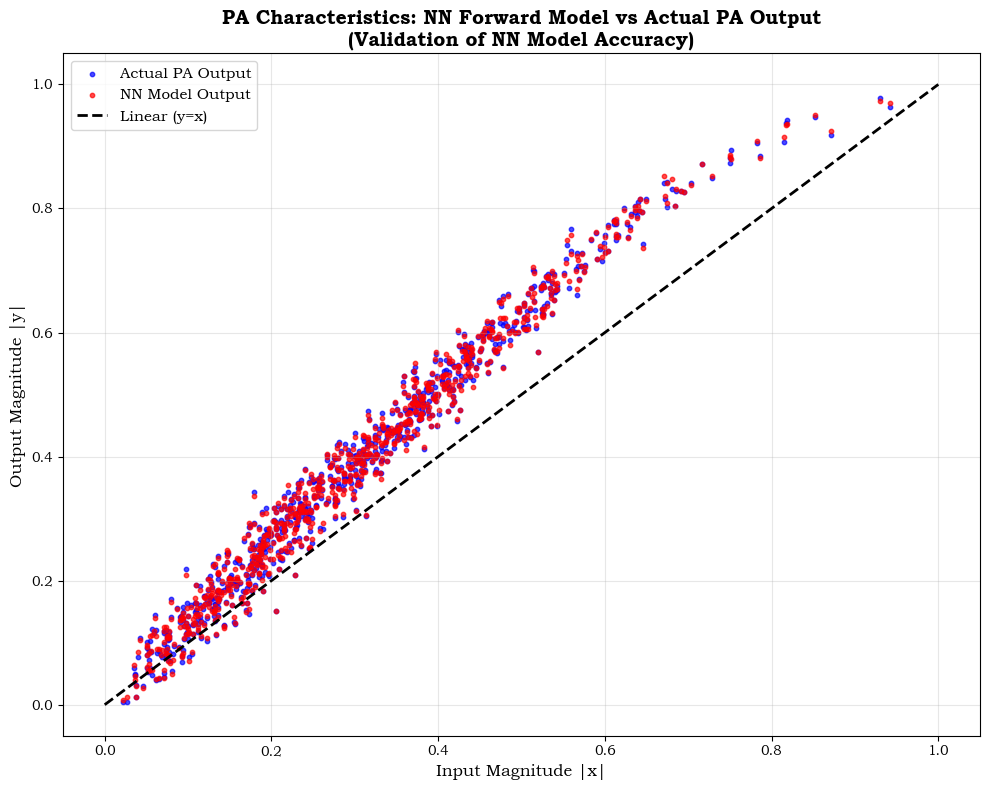

Training Data NMSE: -35.43 dB


In [73]:
# Create forward NN class which extends NN. This will be used to create a forward model of the power amp

class forward_NN(NN):
    def __init__(self, dataset_obj, model_type):
        """
        Forward NN models PA behavior: PA_input (x) -> PA_output (y)
        Training: x = model_training_output (clean PA input), y = model_training_input (PA output)
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_size = dataset_obj.model_training_xfc.shape[1]
        self.pntdnn = self.get_model(model_type)
        self.dataset_obj = dataset_obj
        
        # For forward model: input is clean PA input (x), output is PA output (y)
        # This is opposite to inverse model
        training_input = dataset_obj.model_training_output  # Clean PA input (x)
        training_output = dataset_obj.model_training_input  # PA output (y)
        
        # Build features and expected outputs
        training_input_xfc = dataset_obj.build_xfc(training_input)
        training_phase = dataset_obj.phase_vector(training_input)
        training_expected_output = dataset_obj.model_expected_output(
            training_output, training_phase, dataset_obj.num_memory_levels_nn
        )
        
        # Validation data (forward model)
        valid_input = dataset_obj.model_valid_output  # Clean PA input (x)
        valid_output = dataset_obj.model_valid_input  # PA output (y)
        valid_input_xfc = dataset_obj.build_xfc(valid_input)
        valid_phase = dataset_obj.phase_vector(valid_input)
        valid_expected_output = dataset_obj.model_expected_output(
            valid_output, valid_phase, dataset_obj.num_memory_levels_nn
        )
        
        self.train_loader = self.build_dataloaders(training_input_xfc, training_expected_output)
        self.valid_loader = self.build_dataloaders(valid_input_xfc, valid_expected_output)

    def calculate_nmse(self):
        """Calculate NMSE for forward PA model: how well does NN predict PA output from PA input"""
        test_input = self.dataset_obj.test_input   # Clean PA input (x)
        test_output = self.dataset_obj.test_output  # Actual PA output (y)

        # Build features from test input
        test_input_xfc = self.dataset_obj.build_xfc(test_input)
        
        # Get phase for denormalization
        phase_full = self.dataset_obj.phase_vector(test_input)
        phase = phase_full[self.dataset_obj.num_memory_levels_nn:]
        
        # Get NN prediction [I, Q] and convert to complex
        nn_output_iq = self.evaluate_nn_output(test_input_xfc)
        nn_output_complex = (nn_output_iq[:, 0] + 1j * nn_output_iq[:, 1]) * np.conj(phase)
        
        # Align test_output (trim by num_memory_levels_nn to match nn_output)
        test_output_aligned = test_output[self.dataset_obj.num_memory_levels_nn:]
        
        # Ensure same length
        min_len = min(len(nn_output_complex), len(test_output_aligned))
        nn_output_complex = nn_output_complex[:min_len]
        test_output_aligned = test_output_aligned[:min_len]
        
        # Calculate NMSE in dB
        error_power = np.mean(np.abs(nn_output_complex - test_output_aligned)**2)
        signal_power = np.mean(np.abs(test_output_aligned)**2)
        nmse_db = 10 * np.log10(error_power / signal_power)
        
        return nmse_db
    
    def get_model(self, model_type):
        if model_type == "forward":
            hidden_size = 20
            return PNTDNN(self.input_size, hidden_size)
        else:
            raise ValueError("Unsupported model type")
    
    def plot_nn_vs_actual(self, num_samples=800):
        """
        Plot NN forward model output vs actual PA output to validate model accuracy.
        This shows how well the NN has learned the forward PA characteristic.
        
        Args:
            num_samples: Number of random samples to plot (default 800)
        """
        # Use training data for validation (as in Volterra plot)
        training_input = self.dataset_obj.model_training_output  # Clean PA input (x)
        training_output = self.dataset_obj.model_training_input  # Actual PA output (y)
        
        # Build features from training input
        training_input_xfc = self.dataset_obj.build_xfc(training_input)
        
        # Get phase for denormalization
        phase_full = self.dataset_obj.phase_vector(training_input)
        phase = phase_full[self.dataset_obj.num_memory_levels_nn:]
        
        # Get NN prediction [I, Q] and convert to complex
        nn_output_iq = self.evaluate_nn_output(training_input_xfc)
        nn_output = (nn_output_iq[:, 0] + 1j * nn_output_iq[:, 1]) * np.conj(phase)
        
        # Align actual output
        actual_output = training_output[self.dataset_obj.num_memory_levels_nn:]
        input_trimmed = training_input[self.dataset_obj.num_memory_levels_nn:]
        
        # Ensure all arrays are same length
        min_len = min(len(nn_output), len(actual_output), len(input_trimmed))
        nn_output = nn_output[:min_len]
        actual_output = actual_output[:min_len]
        input_trimmed = input_trimmed[:min_len]
        
        # Select random data points
        total_points = len(input_trimmed)
        random_indices = np.random.choice(total_points, size=min(num_samples, total_points), replace=False)
        
        # Create scatter plot showing PA characteristic: input |x| vs output |y|
        plt.figure(figsize=(10, 8))
        plt.scatter(np.abs(input_trimmed[random_indices]), np.abs(actual_output[random_indices]), 
                    alpha=0.7, label='Actual PA Output', s=10, color='blue')
        plt.scatter(np.abs(input_trimmed[random_indices]), np.abs(nn_output[random_indices]), 
                    alpha=0.7, label='NN Model Output', s=10, color='red')
        plt.plot([0, 1], [0, 1], 'k--', label='Linear (y=x)', linewidth=2)
        plt.xlabel('Input Magnitude |x|', fontsize=12)
        plt.ylabel('Output Magnitude |y|', fontsize=12)
        plt.title('PA Characteristics: NN Forward Model vs Actual PA Output\n(Validation of NN Model Accuracy)', 
                  fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Calculate and print NMSE for training data
        error_power = np.mean(np.abs(nn_output - actual_output)**2)
        signal_power = np.mean(np.abs(actual_output)**2)
        nmse_db = 10 * np.log10(error_power / signal_power)
        print(f"Training Data NMSE: {nmse_db:.2f} dB")


num_forward_memory_levels = 25
data_obj_forward = dataset(x, y, 
                   num_training_points=num_training,
                   num_validation_points=num_validation,
                   num_test_points=num_test,
                   num_memory_levels_nn=num_forward_memory_levels,
                   training_start_idx=training_start)

nn_forward_model = forward_NN(data_obj_forward, model_type="forward")
train_losses, valid_losses, best_epoch = nn_forward_model.get_best_model(num_epochs=300)
print(nn_forward_model.calculate_nmse())
# After training your forward NN model
nn_forward_model.plot_nn_vs_actual(num_samples=800)

In [74]:
# Instantiate and train the inverse model

nn_model = NN(data_obj, model_type="one_layer_15_neurons")

train_losses, valid_losses, best_epoch = nn_model.get_best_model(num_epochs=600)


Epoch  10/600  Loss=3.2998e+00  Valid Loss=1.0253e+00  LR=1.00e-03
Epoch  20/600  Loss=1.6584e+00  Valid Loss=5.5515e-01  LR=1.00e-03
Epoch  20/600  Loss=1.6584e+00  Valid Loss=5.5515e-01  LR=1.00e-03
Epoch  30/600  Loss=1.4598e+00  Valid Loss=4.8912e-01  LR=1.00e-03
Epoch  30/600  Loss=1.4598e+00  Valid Loss=4.8912e-01  LR=1.00e-03
Epoch  40/600  Loss=1.4246e+00  Valid Loss=4.6814e-01  LR=1.00e-03
Epoch  40/600  Loss=1.4246e+00  Valid Loss=4.6814e-01  LR=1.00e-03
Epoch  50/600  Loss=1.4231e+00  Valid Loss=4.6480e-01  LR=1.00e-03
Epoch  50/600  Loss=1.4231e+00  Valid Loss=4.6480e-01  LR=1.00e-03
Epoch  60/600  Loss=1.3692e+00  Valid Loss=4.6708e-01  LR=5.00e-04
Epoch  60/600  Loss=1.3692e+00  Valid Loss=4.6708e-01  LR=5.00e-04
Epoch  70/600  Loss=1.3660e+00  Valid Loss=4.7147e-01  LR=5.00e-04
Epoch  70/600  Loss=1.3660e+00  Valid Loss=4.7147e-01  LR=5.00e-04
Epoch  80/600  Loss=1.3458e+00  Valid Loss=4.5131e-01  LR=2.50e-04
Epoch  80/600  Loss=1.3458e+00  Valid Loss=4.5131e-01  LR=2.50

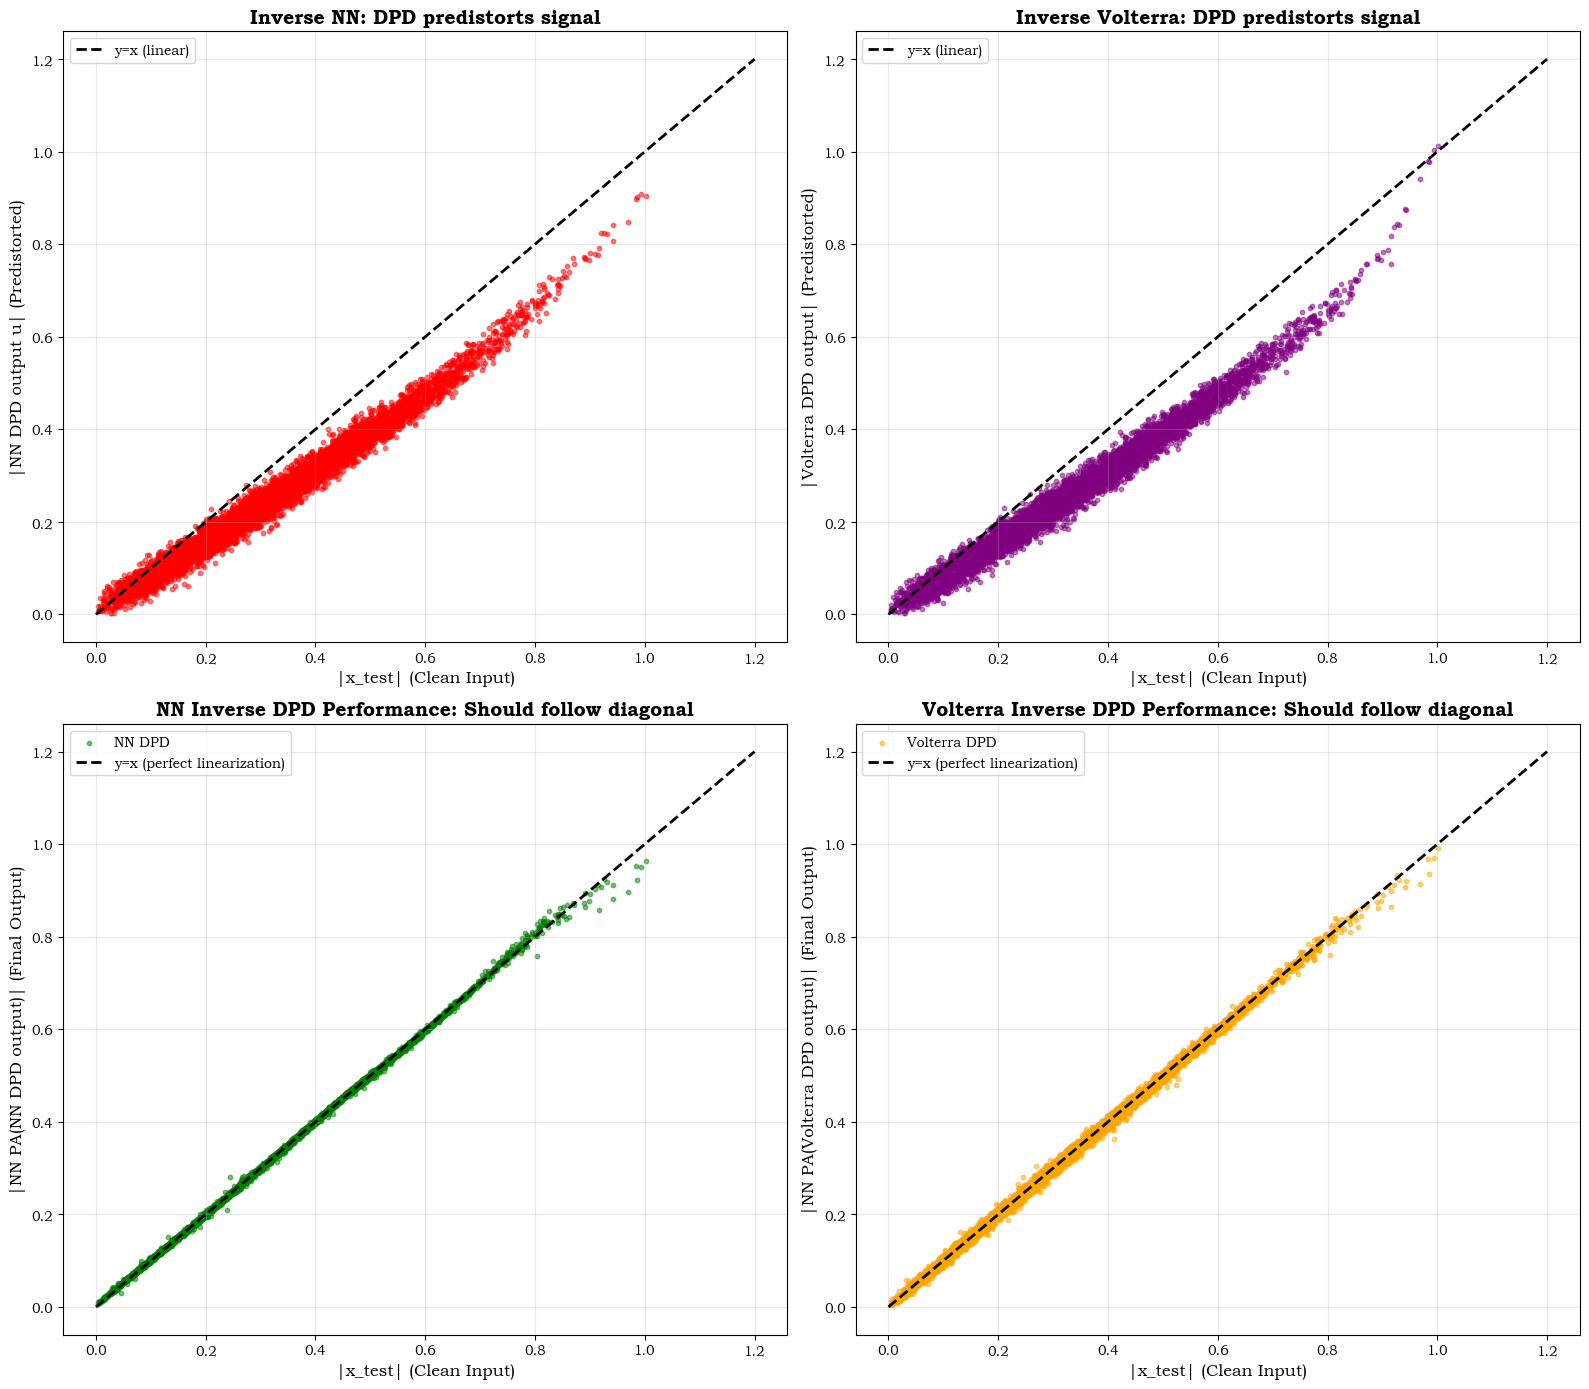


DPD Performance Comparison (both using NN Forward PA Model)

NN Inverse DPD:
  NMSE without DPD:        -8.82 dB
  NMSE with NN DPD:        -39.05 dB
  Improvement:             30.23 dB

Volterra Inverse DPD:
  NMSE without DPD:        -8.82 dB
  NMSE with Volterra DPD:  -31.38 dB
  Improvement:             22.56 dB

Comparison:
  NN DPD advantage:        7.67 dB better



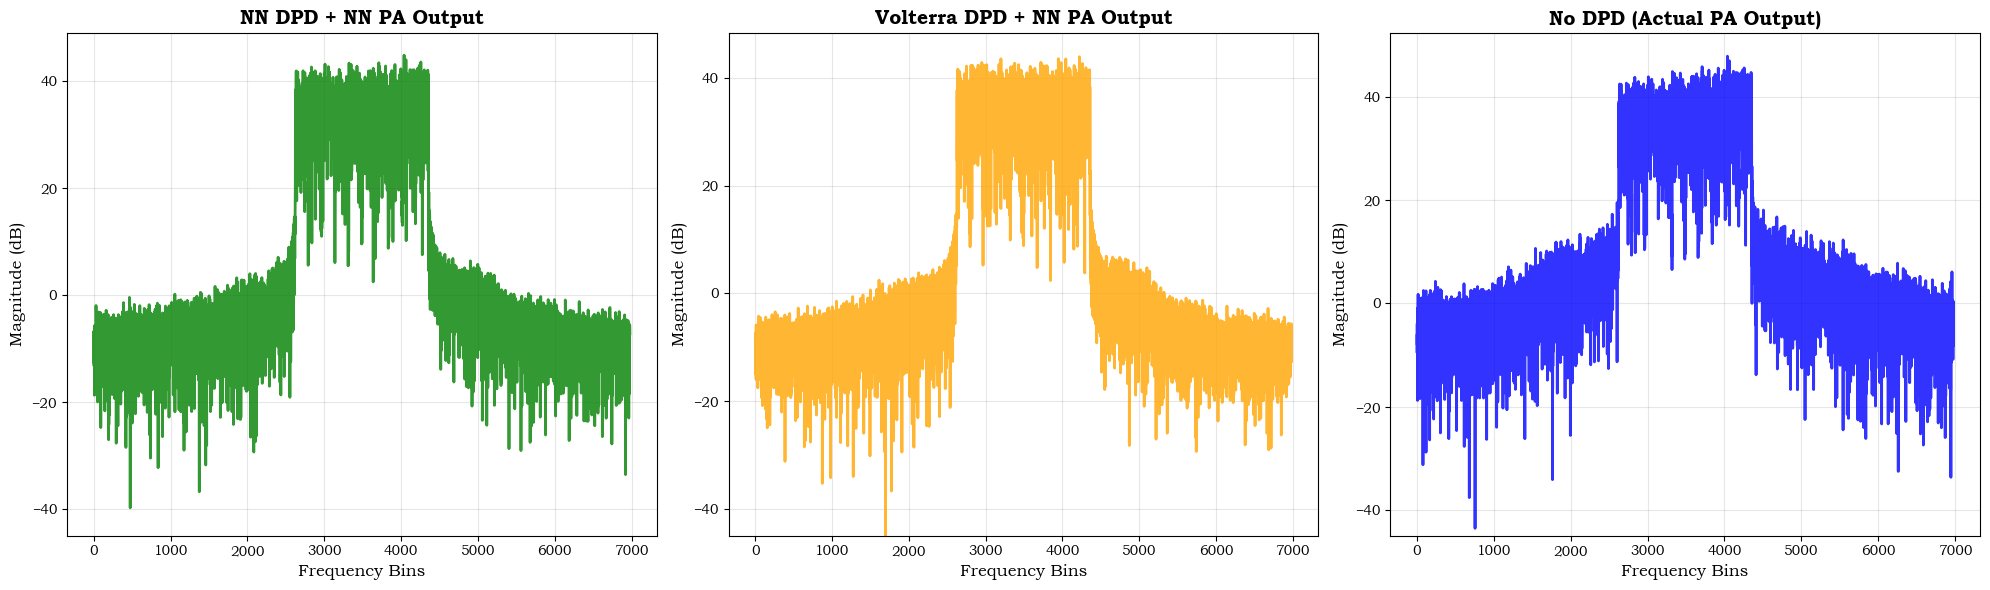

In [ ]:
# Evaluate DPD performance - Comparing Volterra Inverse DPD vs NN Inverse DPD (both using NN PA Model)
x_test, y_test = data_obj.get_leftover_test_data()

# Use same test subset as diagnostic cell for fair comparison
x_test_subset = x_test[:7000]
y_test_subset = y_test[:7000]

# Get NN inverse DPD results through NN forward PA
x_aligned_nn, nn_dpd_output, pa_nn_output_nn = nn_model.evaluate_output_through_pa_nn(
    data_obj, x_test_subset, nn_forward_model
)

# Get Volterra inverse DPD results through NN forward PA
x_aligned_volt, volterra_dpd_output, pa_nn_output_volt = nn_model.evaluate_volterra_inverse_through_pa_nn(
    data_obj, x_test_subset, Volterra_inverse, nn_forward_model
)

# Calculate how much was actually trimmed from the front for each method
actual_trim_nn = len(x_test_subset) - len(x_aligned_nn)
actual_trim_volt = len(x_test_subset) - len(x_aligned_volt)

# Trim y_test by the appropriate amount to ensure perfect alignment
y_test_aligned_nn = y_test_subset[actual_trim_nn:][:len(x_aligned_nn)]
y_test_aligned_volt = y_test_subset[actual_trim_volt:][:len(x_aligned_volt)]

# Create 4 scatter plots comparing DPD methods
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 14))

# Plot 1: NN DPD output (u) vs clean input (x) - Inverse NN characteristic
ax1.scatter(np.abs(x_aligned_nn), np.abs(nn_dpd_output), color='red', alpha=0.5, s=10)
ax1.plot([0, 1.2], [0, 1.2], 'k--', label='y=x (linear)', linewidth=2)
ax1.set_xlabel('|x_test| (Clean Input)', fontsize=12)
ax1.set_ylabel('|NN DPD output u| (Predistorted)', fontsize=12)
ax1.set_title('Inverse NN: DPD predistorts signal', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Volterra DPD output vs clean input (x) - Inverse Volterra characteristic
ax2.scatter(np.abs(x_aligned_volt), np.abs(volterra_dpd_output), color='purple', alpha=0.5, s=10)
ax2.plot([0, 1.2], [0, 1.2], 'k--', label='y=x (linear)', linewidth=2)
ax2.set_xlabel('|x_test| (Clean Input)', fontsize=12)
ax2.set_ylabel('|Volterra DPD output| (Predistorted)', fontsize=12)
ax2.set_title('Inverse Volterra: DPD predistorts signal', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: NN_PA(NN_DPD(x)) vs x - NN DPD linearization performance
ax3.scatter(np.abs(x_aligned_nn), np.abs(pa_nn_output_nn), color='green', alpha=0.5, s=10, label='NN DPD')
ax3.plot([0, 1.2], [0, 1.2], 'k--', label='y=x (perfect linearization)', linewidth=2)
ax3.set_xlabel('|x_test| (Clean Input)', fontsize=12)
ax3.set_ylabel('|NN PA(NN DPD output)| (Final Output)', fontsize=12)
ax3.set_title('NN Inverse DPD Performance: Should follow diagonal', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: NN_PA(Volterra_DPD(x)) vs x - Volterra DPD linearization performance
ax4.scatter(np.abs(x_aligned_volt), np.abs(pa_nn_output_volt), color='orange', alpha=0.5, s=10, label='Volterra DPD')
ax4.plot([0, 1.2], [0, 1.2], 'k--', label='y=x (perfect linearization)', linewidth=2)
ax4.set_xlabel('|x_test| (Clean Input)', fontsize=12)
ax4.set_ylabel('|NN PA(Volterra DPD output)| (Final Output)', fontsize=12)
ax4.set_title('Volterra Inverse DPD Performance: Should follow diagonal', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate NMSE for both methods using NN PA Model
nmse_no_dpd_nn = 10 * np.log10(np.mean(np.abs(y_test_aligned_nn - x_aligned_nn)**2) / np.mean(np.abs(x_aligned_nn)**2))
nmse_with_nn_dpd = 10 * np.log10(np.mean(np.abs(pa_nn_output_nn - x_aligned_nn)**2) / np.mean(np.abs(x_aligned_nn)**2))
improvement_nn = nmse_no_dpd_nn - nmse_with_nn_dpd

nmse_no_dpd_volt = 10 * np.log10(np.mean(np.abs(y_test_aligned_volt - x_aligned_volt)**2) / np.mean(np.abs(x_aligned_volt)**2))
nmse_with_volterra_dpd = 10 * np.log10(np.mean(np.abs(pa_nn_output_volt - x_aligned_volt)**2) / np.mean(np.abs(x_aligned_volt)**2))
improvement_volt = nmse_no_dpd_volt - nmse_with_volterra_dpd

print(f"\n{'='*70}")
print(f"DPD Performance Comparison (both using NN Forward PA Model)")
print(f"{'='*70}")
print(f"\nNN Inverse DPD:")
print(f"  NMSE without DPD:        {nmse_no_dpd_nn:.2f} dB")
print(f"  NMSE with NN DPD:        {nmse_with_nn_dpd:.2f} dB")
print(f"  Improvement:             {improvement_nn:.2f} dB")
print(f"\nVolterra Inverse DPD:")
print(f"  NMSE without DPD:        {nmse_no_dpd_volt:.2f} dB")
print(f"  NMSE with Volterra DPD:  {nmse_with_volterra_dpd:.2f} dB")
print(f"  Improvement:             {improvement_volt:.2f} dB")
print(f"\nComparison:")
print(f"  NN DPD advantage:        {nmse_with_volterra_dpd - nmse_with_nn_dpd:.2f} dB better" if nmse_with_nn_dpd < nmse_with_volterra_dpd else f"  Volterra DPD advantage:  {nmse_with_nn_dpd - nmse_with_volterra_dpd:.2f} dB better")
print(f"{'='*70}\n")

# FFT comparison - NN DPD vs Volterra DPD vs No DPD
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# NN DPD FFT
fs = 800e6  # 800 MHz sampling frequency
Y_nn = np.fft.fftshift(np.fft.fft(pa_nn_output_nn))
Y_nn_dB = 20 * np.log10(np.abs(Y_nn))
freq_nn = np.fft.fftshift(np.fft.fftfreq(len(pa_nn_output_nn), d=1/fs)) / 1e6
ax1.plot(freq_nn, Y_nn_dB, color='green', linewidth=2, alpha=0.8)
ax1.set_title('NN DPD + NN PA Output', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frequency (MHz)', fontsize=12)
ax1.set_ylabel('Magnitude (dB)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([-fs/2e6, fs/2e6])
ax1.set_ylim(bottom=-45)

# Volterra DPD FFT
Y_volt = np.fft.fftshift(np.fft.fft(pa_nn_output_volt))
Y_volt_dB = 20 * np.log10(np.abs(Y_volt))
freq_volt = np.fft.fftshift(np.fft.fftfreq(len(pa_nn_output_volt), d=1/fs)) / 1e6
ax2.plot(freq_volt, Y_volt_dB, color='orange', linewidth=2, alpha=0.8)
ax2.set_title('Volterra DPD + NN PA Output', fontsize=14, fontweight='bold')
ax2.set_xlabel('Frequency (MHz)', fontsize=12)
ax2.set_ylabel('Magnitude (dB)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([-fs/2e6, fs/2e6])
ax2.set_ylim(bottom=-45)

# No DPD FFT
Y_no_dpd = np.fft.fftshift(np.fft.fft(y_test_aligned_nn))
Y_no_dpd_dB = 20 * np.log10(np.abs(Y_no_dpd))
freq_no_dpd = np.fft.fftshift(np.fft.fftfreq(len(y_test_aligned_nn), d=1/fs)) / 1e6
ax3.plot(freq_no_dpd, Y_no_dpd_dB, color='blue', linewidth=2, alpha=0.8)
ax3.set_title('No DPD (Actual PA Output)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Frequency (MHz)', fontsize=12)
ax3.set_ylabel('Magnitude (dB)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([-fs/2e6, fs/2e6])
ax3.set_ylim(bottom=-45)

plt.tight_layout()
plt.show()

In [ ]:
class Experiment:
    def __init__(self, nn_model, num_prune_iterations, prune_amount, retrain_epochs, dataset_obj, forward_nn_model, num_test_points=5000):
        self.original_nn_model = nn_model  # Keep original model untouched
        self.nn_model_copy = nn_model  # Will be set to working copy
        self.num_prune_iterations = num_prune_iterations
        self.prune_amount = prune_amount
        self.retrain_epochs = retrain_epochs
        self.model_xfc = dataset_obj.model_training_xfc
        self.model_training_expected_output = dataset_obj.model_training_expected_output
        self.valid_xfc = dataset_obj.model_valid_input
        self.model_valid_expected_output = dataset_obj.model_valid_expected_output
        self.num_test_points = num_test_points
        self.test_data =self.original_nn_model.dataset_obj.test_input[:num_test_points]
        self.forward_nn_model = forward_nn_model  # Store forward NN PA model
    
    def run(self):
        nmse_results = []
        prune_percentages = []
        valid_losses_final = []
        all_valid_losses = []
        all_best_epochs = []
        
        # Create a working copy from the original model
        working_pntdnn = copy.deepcopy(self.original_nn_model.pntdnn)
        initial_nmse = self.nn_model_copy.calculate_nmse_with_nn_pa(self.forward_nn_model, self.test_data)
        
        # Calculate initial validation loss
        criterion = nn.MSELoss()
        self.nn_model_copy.pntdnn.eval()
        with torch.no_grad():
            initial_valid_loss = 0
            for xb, yb in self.nn_model_copy.valid_loader:
                preds = self.nn_model_copy.pntdnn(xb)
                loss = criterion(preds, yb)
                initial_valid_loss += loss.item() * xb.size(0)

        for i in range(self.num_prune_iterations):
            print(f"\n{'='*60}")
            print(f"Pruning Iteration {i+1}/{self.num_prune_iterations}")
            print(f"{'='*60}")
            
            # Apply pruning to the current model (iterative pruning of remaining weights)
            print(f"Pruning {self.prune_amount*100:.1f}% of remaining weights...")
            self.nn_model_copy.prune_model(["fc1", "fc2"], self.prune_amount)
            
            # Calculate current pruning percentage
            current_prune_pct = self.nn_model_copy.get_pruning_percentage()
            prune_percentages.append(current_prune_pct)
            print(f"Current pruning: {current_prune_pct:.2f}% of weights are zero")
            
            # Retrain the model
            print(f"Retraining for {self.retrain_epochs} epochs...")
            train_losses, valid_losses, best_epoch = self.nn_model_copy.get_best_model(
                num_epochs=self.retrain_epochs
            )
            
            # Store validation losses and best epoch
            all_valid_losses.append(valid_losses)
            all_best_epochs.append(best_epoch)
            valid_losses_final.append(min(valid_losses))
            
            # Calculate NMSE
            nmse = self.nn_model_copy.calculate_nmse_with_nn_pa(self.forward_nn_model, self.test_data)
            nmse_results.append(nmse)
            print(f"NMSE: {nmse:.4f} dB")

        self.plot_results(prune_percentages, nmse_results, valid_losses_final, initial_nmse, initial_valid_loss)
        # self.plot_training_curves(all_valid_losses, all_best_epochs, prune_percentages)
        
        return prune_percentages, nmse_results, valid_losses_final

    def plot_results(self, prune_percentages, nmse_results, valid_losses, initial_nmse, initial_valid_loss):
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        # Add the initial values to the results
        nmse_results.insert(0, initial_nmse)
        prune_percentages.insert(0, 0)
        valid_losses.insert(0, initial_valid_loss)
        
        # Plot NMSE
        ax.plot(prune_percentages, nmse_results, marker='o', linewidth=2, markersize=8, color='tab:blue')
        ax.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax.set_ylabel('NMSE (dB)', fontsize=12)
        ax.set_title('Model Performance vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_training_curves(self, all_valid_losses, all_best_epochs, prune_percentages):
        """Plot validation loss curves for each pruning iteration with best epoch markers"""
        n_iterations = len(all_valid_losses)
        colors = plt.cm.viridis(np.linspace(0, 1, n_iterations))
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for i, (valid_losses, best_epoch, prune_pct, color) in enumerate(zip(all_valid_losses, all_best_epochs, prune_percentages, colors)):
            epochs = range(1, len(valid_losses) + 1)
            label = f'Iter {i+1}: {prune_pct:.1f}% pruned'
            
            # Plot validation loss curve
            ax.plot(epochs, valid_losses, linewidth=2, color=color, label=label, alpha=0.7)
            
            # Add vertical line at best epoch
            ax.axvline(x=best_epoch, color=color, linestyle='--', linewidth=1.5, alpha=0.8)
            
            # Add marker at best epoch
            best_loss = valid_losses[best_epoch - 1]
            ax.plot(best_epoch, best_loss, marker='*', markersize=12, color=color, 
                   markeredgecolor='black', markeredgewidth=1)
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Validation Loss', fontsize=12)
        ax.set_title('Validation Loss Curves for Each Pruning Iteration', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    

In [ ]:
# Run linear pruning experiment
print("="*70)
print("RUNNING LINEAR PRUNING EXPERIMENT")
print("="*70)
linear_experiment = Experiment(nn_model, num_prune_iterations=10, prune_amount=0.2, retrain_epochs=200,
                               dataset_obj=data_obj, forward_nn_model=nn_forward_model)
linear_prune_pct, linear_nmse, linear_valid = linear_experiment.run()

RUNNING LINEAR PRUNING EXPERIMENT

Pruning Iteration 1/10
Pruning 20.0% of remaining weights...
Current pruning: 20.00% of weights are zero
Retraining for 200 epochs...
Epoch  10/200  Loss=1.1121e+00  Valid Loss=3.6957e-01  LR=1.00e-03
Epoch  10/200  Loss=1.1121e+00  Valid Loss=3.6957e-01  LR=1.00e-03
Epoch  20/200  Loss=1.0600e+00  Valid Loss=3.6514e-01  LR=1.00e-03
Epoch  20/200  Loss=1.0600e+00  Valid Loss=3.6514e-01  LR=1.00e-03
Epoch  30/200  Loss=1.0507e+00  Valid Loss=3.5261e-01  LR=1.00e-03
Epoch  30/200  Loss=1.0507e+00  Valid Loss=3.5261e-01  LR=1.00e-03
Epoch  40/200  Loss=1.0076e+00  Valid Loss=3.4586e-01  LR=5.00e-04
Epoch  40/200  Loss=1.0076e+00  Valid Loss=3.4586e-01  LR=5.00e-04
Epoch  50/200  Loss=1.0057e+00  Valid Loss=3.4578e-01  LR=5.00e-04
Epoch  50/200  Loss=1.0057e+00  Valid Loss=3.4578e-01  LR=5.00e-04
Epoch  60/200  Loss=1.0145e+00  Valid Loss=3.6148e-01  LR=2.50e-04
Epoch  60/200  Loss=1.0145e+00  Valid Loss=3.6148e-01  LR=2.50e-04
Epoch  70/200  Loss=9.9619e

KeyboardInterrupt: 

In [ ]:
class Non_Linear_Prune_Experiment:
    def __init__(self, nn_model, prune_schedule, retrain_epochs, model_xfc, model_training_expected_output, valid_xfc, model_valid_expected_output):
        """
        Args:
            nn_model: The trained neural network model
            prune_schedule: List of pruning amounts for each iteration (e.g., [0.5, 0.2, 0.1, 0.05, 0.05])
            retrain_epochs: Number of epochs to retrain after each pruning
            model_xfc: Training features
            model_training_expected_output: Training targets
            valid_xfc: Validation features
            model_valid_expected_output: Validation targets
        """
        self.original_nn_model = nn_model  # Keep original model untouched
        self.nn_model = None  # Will be set to working copy
        self.prune_schedule = prune_schedule
        self.num_prune_iterations = len(prune_schedule)
        self.retrain_epochs = retrain_epochs
        self.model_xfc = model_xfc
        self.model_training_expected_output = model_training_expected_output
        self.valid_xfc = valid_xfc
        self.model_valid_expected_output = model_valid_expected_output
    
    def run(self):
        nmse_results = []
        prune_percentages = []
        valid_losses_final = []
        all_valid_losses = []
        all_best_epochs = []
        
        # Create a working copy from the original model
        working_pntdnn = copy.deepcopy(self.original_nn_model.pntdnn)
        self.nn_model = NN(working_pntdnn, self.model_xfc, self.model_training_expected_output, self.valid_xfc)

        for i in range(self.num_prune_iterations):
            print(f"\n{'='*60}")
            print(f"Pruning Iteration {i+1}/{self.num_prune_iterations}")
            print(f"{'='*60}")
            
            # Apply pruning to the current model (iterative pruning of remaining weights)
            print(f"Pruning {self.prune_schedule[i]*100:.1f}% of remaining weights...")
            self.nn_model.prune_model(["fc1", "fc2"], self.prune_schedule[i])
            
            # Calculate current pruning percentage
            current_prune_pct = self.nn_model.get_pruning_percentage()
            prune_percentages.append(current_prune_pct)
            print(f"Current pruning: {current_prune_pct:.2f}% of weights are zero")
            
            # Retrain the model
            print(f"Retraining for {self.retrain_epochs} epochs...")
            train_losses, valid_losses, best_epoch = self.nn_model.get_best_model(
                num_epochs=self.retrain_epochs
            )
            
            # Store validation losses and best epoch
            all_valid_losses.append(valid_losses)
            all_best_epochs.append(best_epoch)
            valid_losses_final.append(min(valid_losses))
            
            # Calculate NMSE
            nmse = self.nn_model.calculate_nmse()
            nmse_results.append(nmse)
            print(f"NMSE: {nmse:.4f} dB")

        self.plot_results(prune_percentages, nmse_results, valid_losses_final)
        
        return prune_percentages, nmse_results, valid_losses_final

    def plot_results(self, prune_percentages, nmse_results, valid_losses):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot NMSE
        ax1.plot(prune_percentages, nmse_results, marker='o', linewidth=2, markersize=8, color='tab:blue')
        ax1.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax1.set_ylabel('NMSE (dB)', fontsize=12)
        ax1.set_title('Model Performance vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Plot Validation Loss
        ax2.plot(prune_percentages, valid_losses, marker='s', linewidth=2, markersize=8, color='tab:orange')
        ax2.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax2.set_ylabel('Best Validation Loss', fontsize=12)
        ax2.set_title('Validation Loss vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_training_curves(self, all_valid_losses, all_best_epochs, prune_percentages):
        """Plot validation loss curves for each pruning iteration with best epoch markers"""
        n_iterations = len(all_valid_losses)
        colors = plt.cm.viridis(np.linspace(0, 1, n_iterations))
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for i, (valid_losses, best_epoch, prune_pct, color) in enumerate(zip(all_valid_losses, all_best_epochs, prune_percentages, colors)):
            epochs = range(1, len(valid_losses) + 1)
            label = f'Iter {i+1}: {prune_pct:.1f}% pruned'
            
            # Plot validation loss curve
            ax.plot(epochs, valid_losses, linewidth=2, color=color, label=label, alpha=0.7)
            
            # Add vertical line at best epoch
            ax.axvline(x=best_epoch, color=color, linestyle='--', linewidth=1.5, alpha=0.8)
            
            # Add marker at best epoch
            best_loss = valid_losses[best_epoch - 1]
            ax.plot(best_epoch, best_loss, marker='*', markersize=12, color=color, 
                   markeredgecolor='black', markeredgewidth=1)
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Validation Loss', fontsize=12)
        ax.set_title('Validation Loss Curves for Each Pruning Iteration', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def compare_pruning_strategies(linear_results, nonlinear_results):
        """
        Compare linear and non-linear pruning strategies side by side
        
        Args:
            linear_results: tuple of (prune_percentages, nmse_results, valid_losses)
            nonlinear_results: tuple of (prune_percentages, nmse_results, valid_losses)
        """
        linear_prune_pct, linear_nmse, linear_valid = linear_results
        nonlinear_prune_pct, nonlinear_nmse, nonlinear_valid = nonlinear_results
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot NMSE comparison
        ax1.plot(linear_prune_pct, linear_nmse, marker='o', linewidth=2, markersize=8, 
                color='tab:blue', label='Linear Pruning')
        ax1.plot(nonlinear_prune_pct, nonlinear_nmse, marker='s', linewidth=2, markersize=8, 
                color='tab:red', label='Non-Linear Pruning')
        ax1.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax1.set_ylabel('NMSE (dB)', fontsize=12)
        ax1.set_title('Model Performance: Linear vs Non-Linear Pruning', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Plot Validation Loss comparison
        ax2.plot(linear_prune_pct, linear_valid, marker='o', linewidth=2, markersize=8, 
                color='tab:blue', label='Linear Pruning')
        ax2.plot(nonlinear_prune_pct, nonlinear_valid, marker='s', linewidth=2, markersize=8, 
                color='tab:red', label='Non-Linear Pruning')
        ax2.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax2.set_ylabel('Best Validation Loss', fontsize=12)
        ax2.set_title('Validation Loss: Linear vs Non-Linear Pruning', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    



In [ ]:
# Run non-linear pruning experiment
print("\n" + "="*70)
print("RUNNING NON-LINEAR PRUNING EXPERIMENT")
print("="*70)
nonlinear_prune_schedule = [0.5, 0.5, 0.1, 0.1]  # Custom pruning schedule
nonlinear_experiment = Non_Linear_Prune_Experiment(nn_model, prune_schedule=nonlinear_prune_schedule, 
                                                    retrain_epochs=500,
                                                    model_xfc=model_xfc, 
                                                    model_training_expected_output=model_training_expected_output,
                                                    valid_xfc=valid_xfc, 
                                                    model_valid_expected_output=model_valid_expected_output)
nonlinear_prune_pct, nonlinear_nmse, nonlinear_valid = nonlinear_experiment.run()

# Compare both strategies
print("\n" + "="*70)
print("COMPARING PRUNING STRATEGIES")
print("="*70)
Non_Linear_Prune_Experiment.compare_pruning_strategies(
    (linear_prune_pct, linear_nmse, linear_valid),
    (nonlinear_prune_pct, nonlinear_nmse, nonlinear_valid)
)


RUNNING NON-LINEAR PRUNING EXPERIMENT


NameError: name 'model_xfc' is not defined

In [ ]:
# Experiment on just pruning F1

class Prune_fc1_only_Experiment:
    def __init__(self, nn_model, num_prune_iterations, prune_amount, retrain_epochs, model_xfc, model_training_expected_output, valid_xfc, model_valid_expected_output):
        self.original_nn_model = nn_model  # Keep original model untouched
        self.nn_model = None  # Will be set to working copy
        self.num_prune_iterations = num_prune_iterations
        self.prune_amount = prune_amount
        self.retrain_epochs = retrain_epochs
        self.model_xfc = model_xfc
        self.model_training_expected_output = model_training_expected_output
        self.valid_xfc = valid_xfc
        self.model_valid_expected_output = model_valid_expected_output
    
    def run(self):
        nmse_results = []
        prune_percentages = []
        valid_losses_final = []
        all_valid_losses = []
        all_best_epochs = []
        
        # Create a working copy from the original model
        working_pntdnn = copy.deepcopy(self.original_nn_model.pntdnn)
        self.nn_model = NN(working_pntdnn)

        for i in range(self.num_prune_iterations):
            print(f"\n{'='*60}")
            print(f"Pruning Iteration {i+1}/{self.num_prune_iterations}")
            print(f"{'='*60}")
            
            # Apply pruning to the current model (iterative pruning of remaining weights)
            print(f"Pruning {self.prune_amount*100:.1f}% of remaining fc1 weights...")
            self.nn_model.prune_model(["fc1"], self.prune_amount)
            
            # Calculate current pruning percentage
            current_prune_pct = self.nn_model.get_pruning_percentage()
            prune_percentages.append(current_prune_pct)
            print(f"Current pruning: {current_prune_pct:.2f}% of weights are zero")
            
            # Retrain the model
            print(f"Retraining for {self.retrain_epochs} epochs...")
            train_loader = self.nn_model.build_dataloaders(self.model_xfc, self.model_training_expected_output)
            valid_loader = self.nn_model.build_dataloaders(self.valid_xfc, self.model_valid_expected_output)
            train_losses, valid_losses, best_epoch = self.nn_model.get_best_model(
                train_loader, valid_loader, num_epochs=self.retrain_epochs
            )
            
            # Store validation losses and best epoch
            all_valid_losses.append(valid_losses)
            all_best_epochs.append(best_epoch)
            valid_losses_final.append(min(valid_losses))
            
            # Calculate NMSE
            nmse = self.nn_model.calculate_nmse()
            nmse_results.append(nmse)
            print(f"NMSE: {nmse:.4f} dB")

        self.plot_results(prune_percentages, nmse_results, valid_losses_final)
        # self.plot_training_curves(all_valid_losses, all_best_epochs, prune_percentages)
        
        return prune_percentages, nmse_results, valid_losses_final

    def plot_results(self, prune_percentages, nmse_results, valid_losses):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot NMSE
        ax1.plot(prune_percentages, nmse_results, marker='o', linewidth=2, markersize=8, color='tab:blue')
        ax1.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax1.set_ylabel('NMSE (dB)', fontsize=12)
        ax1.set_title('Model Performance vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Plot Validation Loss
        ax2.plot(prune_percentages, valid_losses, marker='s', linewidth=2, markersize=8, color='tab:orange')
        ax2.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax2.set_ylabel('Best Validation Loss', fontsize=12)
        ax2.set_title('Validation Loss vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_training_curves(self, all_valid_losses, all_best_epochs, prune_percentages):
        """Plot validation loss curves for each pruning iteration with best epoch markers"""
        n_iterations = len(all_valid_losses)
        colors = plt.cm.viridis(np.linspace(0, 1, n_iterations))
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for i, (valid_losses, best_epoch, prune_pct, color) in enumerate(zip(all_valid_losses, all_best_epochs, prune_percentages, colors)):
            epochs = range(1, len(valid_losses) + 1)
            label = f'Iter {i+1}: {prune_pct:.1f}% pruned'
            
            # Plot validation loss curve
            ax.plot(epochs, valid_losses, linewidth=2, color=color, label=label, alpha=0.7)
            
            # Add vertical line at best epoch
            ax.axvline(x=best_epoch, color=color, linestyle='--', linewidth=1.5, alpha=0.8)
            
            # Add marker at best epoch
            best_loss = valid_losses[best_epoch - 1]
            ax.plot(best_epoch, best_loss, marker='*', markersize=12, color=color, 
                   markeredgecolor='black', markeredgewidth=1)
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Validation Loss', fontsize=12)
        ax.set_title('Validation Loss Curves for Each Pruning Iteration', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    

In [ ]:
# Run fc1 only pruning experiment
print("="*70)
print("RUNNING FC1 ONLY PRUNING EXPERIMENT")
print("="*70)
fc1_only_experiment = Prune_fc1_only_Experiment(nn_model, num_prune_iterations=20, prune_amount=0.1, retrain_epochs=200,
                               model_xfc=model_xfc, model_training_expected_output=model_training_expected_output,
                               valid_xfc=valid_xfc, model_valid_expected_output=model_valid_expected_output)
fc1_prune_pct, fc1_nmse, fc1_valid = fc1_only_experiment.run()

In [ ]:
# Train 3 layer NN
# Instantiate and train the model
input_size = model_xfc.shape[1]
hidden_size_1 = 12
hidden_size_2e = 2
PNTDNN_3_layers_model = PNTDNN_3_layers(input_size, hidden_size_1, hidden_sze_2, utput


_
size)


In [ ]:
# Train a 1 layer model with a bigger hidden layer
input_size = model_xfc.shape[1]
hidden_size = 20
output_size = 2
pntdnn = PNTDNN(input_size, hidden_size)
nn_model = NN(pntdnn)
train_loader = nn_model.build_dataloaders(model_xfc, model_training_expected_output)
valid_loader = nn_model.build_dataloaders(valid_xfc, model_valid_expected_output)
train_losses, valid_losses, best_epoch = nn_model.get_best_model(train_loader, valid_loader, num_epochs=2000)
print(nn_model.calculate_nmse(model_xfc, model_training_expected_output))


In [ ]:
# Train a model with 1 smaller hidden layer
input_size = model_xfc.shape[1]
hidden_size = 7
output_size = 2
pntdnn = PNTDNN(input_size, hidden_size, output_size)
nn_model = NN(pntdnn)
train_loader = nn_model.build_dataloaders(model_xfc, model_training_expected_output)
valid_loader = nn_model.build_dataloaders(valid_xfc, model_valid_expected_output)
train_losses, valid_losses, best_epoch = nn_model.get_best_model(train_loader, valid_loader, num_epochs=2000)
print(nn_model.calculate_nmse(model_xfc, model_training_expected_output))

